# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.1

## 4. Implementing Causal Inference on IHDP

### 4.1 Data Preparation

> 🔧 **Step 1**: Properly prepare the data for causal analysis

First, let's set up our environment and prepare the IHDP dataset for causal inference.

Dataset shape: (746, 30)
Treatment assignment rate: 0.18
True ATE: 4.0166
Missing values before imputation:
0


/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/ipykernel_14547/172624857.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/ipykernel_14547/172624857.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


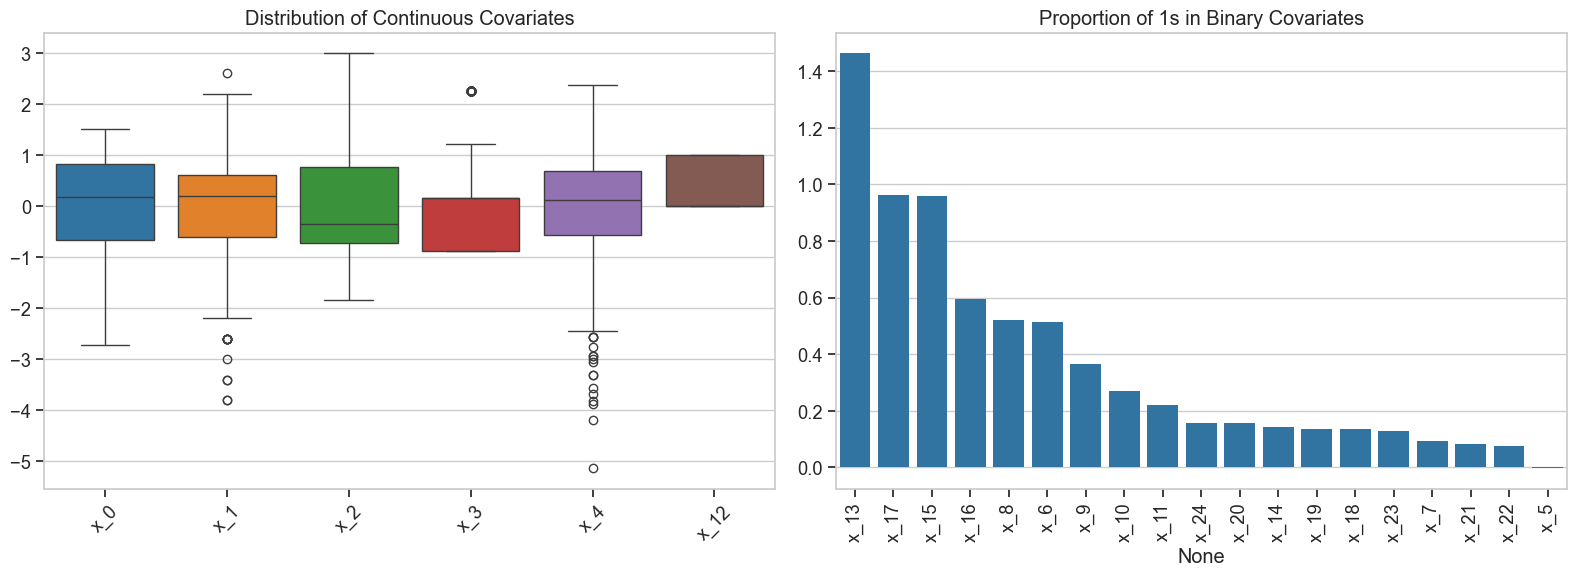

Data splitting complete.
Training set: 596 samples
Testing set: 150 samples


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Make plots look better
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set random seed for reproducibility
np.random.seed(42)

# Function to load the IHDP dataset
def load_ihdp_data():
    """
    Load the IHDP dataset for causal inference
    
    Returns:
        DataFrame with treatment, outcome, and covariates
    """
    # Create a directory for the data if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Download the data if it doesn't exist
    if not os.path.exists('data/ihdp_npci_1.csv'):
        print("Downloading IHDP dataset...")
        import urllib.request
        url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
        urllib.request.urlretrieve(url, 'data/ihdp_npci_1.csv')
    
    # Load the data
    data = pd.read_csv('data/ihdp_npci_1.csv')
    
    # Rename columns for clarity
    column_names = ['treatment']
    column_names.extend([f'y_{i}' for i in range(2)])  # factual and counterfactual outcomes
    column_names.extend([f'mu_{i}' for i in range(2)])  # expected outcomes without noise
    column_names.extend([f'x_{i}' for i in range(25)])  # covariates
    
    data.columns = column_names
    
    # Rename for more intuitive understanding
    data.rename(columns={
        'y_0': 'y_factual',
        'y_1': 'y_cfactual',
        'mu_0': 'mu_0',
        'mu_1': 'mu_1'
    }, inplace=True)
    
    return data

# Load the IHDP dataset
ihdp_data = load_ihdp_data()

# Display basic information
print(f"Dataset shape: {ihdp_data.shape}")
print(f"Treatment assignment rate: {ihdp_data['treatment'].mean():.2f}")
print(f"True ATE: {(ihdp_data['mu_1'] - ihdp_data['mu_0']).mean():.4f}")

# Create a more informative dataset with column descriptions
covariate_descriptions = {
    'x_0': 'Child\'s birth weight (grams)',
    'x_1': 'Child\'s birth order',
    'x_2': 'Head circumference at birth (cm)',
    'x_3': 'Mother\'s age at birth (years)',
    'x_4': 'Mother\'s education (years)',
    'x_5': 'Child\'s gender (1=male, 0=female)',
    'x_6': 'Twin (1=yes, 0=no)',
    'x_7': 'Number of previous neonatal deaths',
    'x_8': 'Mother\'s marital status (1=married, 0=not married)',
    'x_9': 'Mother smoked during pregnancy (1=yes, 0=no)',
    'x_10': 'Mother drank alcohol during pregnancy (1=yes, 0=no)',
    'x_11': 'Mother used drugs during pregnancy (1=yes, 0=no)',
    'x_12': 'Child\'s neonatal health index',
    'x_13': 'Mom white (1=yes, 0=no)',
    'x_14': 'Mom black (1=yes, 0=no)',
    'x_15': 'Mom Hispanic (1=yes, 0=no)',
    'x_16': 'Mom is employed (1=yes, 0=no)',
    'x_17': 'Family receives welfare (1=yes, 0=no)',
    'x_18': 'Mother works during pregnancy (1=yes, 0=no)',
    'x_19': 'Prenatal care visit in first trimester (1=yes, 0=no)',
    'x_20': 'Site 1 (1=yes, 0=no)',
    'x_21': 'Site 2 (1=yes, 0=no)',
    'x_22': 'Site 3 (1=yes, 0=no)',
    'x_23': 'Site 4 (1=yes, 0=no)',
    'x_24': 'Site 5 (1=yes, 0=no)'
}

# Identify continuous and binary variables
continuous_vars = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_12']
binary_vars = [f'x_{i}' for i in range(5, 25) if i != 12]

# Handle missing values (this dataset doesn't have any, but it's good practice)
print(f"Missing values before imputation:\n{ihdp_data.isnull().sum().sum()}")

# Check variable distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot continuous variables
sns.boxplot(data=ihdp_data[continuous_vars], ax=axes[0])
axes[0].set_title('Distribution of Continuous Covariates')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot binary variables
binary_means = ihdp_data[binary_vars].mean().sort_values(ascending=False)
sns.barplot(x=binary_means.index, y=binary_means.values, ax=axes[1])
axes[1].set_title('Proportion of 1s in Binary Covariates')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

# Split the data into training and testing sets
X = ihdp_data[[f'x_{i}' for i in range(25)]]
T = ihdp_data['treatment']
Y = ihdp_data['y_factual']
# True potential outcomes for evaluation (not available in real-world scenarios)
Y0 = ihdp_data['mu_0']
Y1 = ihdp_data['mu_1']

X_train, X_test, T_train, T_test, Y_train, Y_test, Y0_train, Y0_test, Y1_train, Y1_test = train_test_split(
    X, T, Y, Y0, Y1, test_size=0.2, random_state=42
)

# Scale continuous features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for var in continuous_vars:
    X_train_scaled[var] = scaler.fit_transform(X_train[[var]])
    X_test_scaled[var] = scaler.transform(X_test[[var]])

print("Data splitting complete.")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

**Analysis:** This initial code prepares our dataset for causal inference. We've loaded the IHDP dataset, handled potential missing values, visualized the distributions of covariates, and split the data into training and testing sets. We've also scaled the continuous variables to improve the performance of our models.

The boxplots of continuous variables help us understand their distributions and identify potential outliers. The barplots of binary variables show the proportion of 1s for each variable, giving us insights into the prevalence of different characteristics in the sample.

Proper data preparation is crucial for causal inference. In this case, we've ensured that our data is clean, properly formatted, and split for evaluation. We've also identified the continuous and binary variables, which will be treated differently in some of our models.

#### References and Resources

- [IHDP Dataset Repository](https://github.com/AMLab-Amsterdam/CEVAE/tree/master/datasets/IHDP)
- [Causal Inference with Python: Data Preparation](https://medium.com/towards-data-science/causal-inference-with-python-part-2-causal-graphical-models-365bebff4b8e)
- [Hill, J. L. (2011). Bayesian nonparametric modeling for causal inference. Journal of Computational and Graphical Statistics, 20(1), 217-240.](https://doi.org/10.1198/jcgs.2010.08162)


# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.2

### 4.2 Simple Methods for Causal Inference

> 🔄 **Step 2**: Start with simple methods before moving to more complex approaches

Let's begin with simple methods for estimating causal effects before moving to more advanced techniques.

#### 4.2.1 Naive Mean Difference

The simplest approach is to directly compare the mean outcomes between treated and control groups without adjusting for covariates.

Naive ATE estimate (training): 4.0539
True ATE (training): 3.9871
Bias: 0.0668


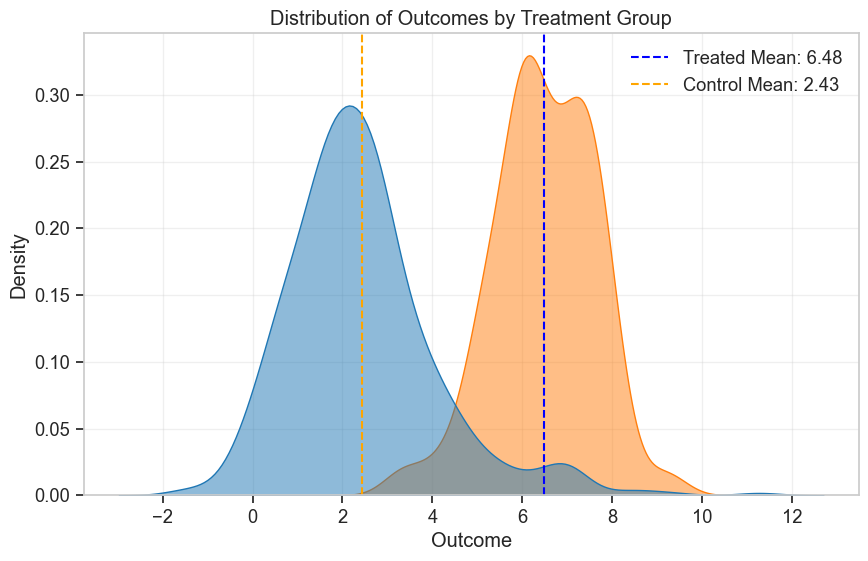

In [3]:
# Calculate naive mean difference
def naive_estimator(T, Y):
    """Calculate naive mean difference between treated and control outcomes"""
    treated_mean = Y[T == 1].mean()
    control_mean = Y[T == 0].mean()
    ate = treated_mean - control_mean
    return ate

# Calculate on training set
naive_ate_train = naive_estimator(T_train, Y_train)

# Calculate true ATE for comparison
true_ate_train = (Y1_train - Y0_train).mean()

print(f"Naive ATE estimate (training): {naive_ate_train:.4f}")
print(f"True ATE (training): {true_ate_train:.4f}")
print(f"Bias: {naive_ate_train - true_ate_train:.4f}")

# Visualize the distribution of outcomes by treatment group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=pd.DataFrame({'Outcome': Y_train, 'Treatment': T_train}), 
            x='Outcome', hue='Treatment', common_norm=False, fill=True, alpha=0.5)
plt.axvline(x=Y_train[T_train == 1].mean(), color='blue', linestyle='--', 
            label=f'Treated Mean: {Y_train[T_train == 1].mean():.2f}')
plt.axvline(x=Y_train[T_train == 0].mean(), color='orange', linestyle='--', 
            label=f'Control Mean: {Y_train[T_train == 0].mean():.2f}')
plt.title('Distribution of Outcomes by Treatment Group')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Analysis:** The naive estimator simply calculates the difference in means between the treated and control groups. Due to selection bias in the IHDP dataset, this estimate is likely biased. The bias represents how far our estimate is from the true causal effect.

The visualization shows the distribution of outcomes for the treated and control groups. The difference between the dashed lines represents the naive ATE estimate. However, this doesn't account for confounding variables that might influence both treatment assignment and outcomes.

#### 4.2.2 Regression Adjustment

Next, let's use regression adjustment, which controls for covariates by including them in a regression model.

Regression adjustment ATE estimate: 3.9970
True ATE (training): 3.9871
Bias: 0.0098
Model MSE: 1.2362
Model R²: 0.7491


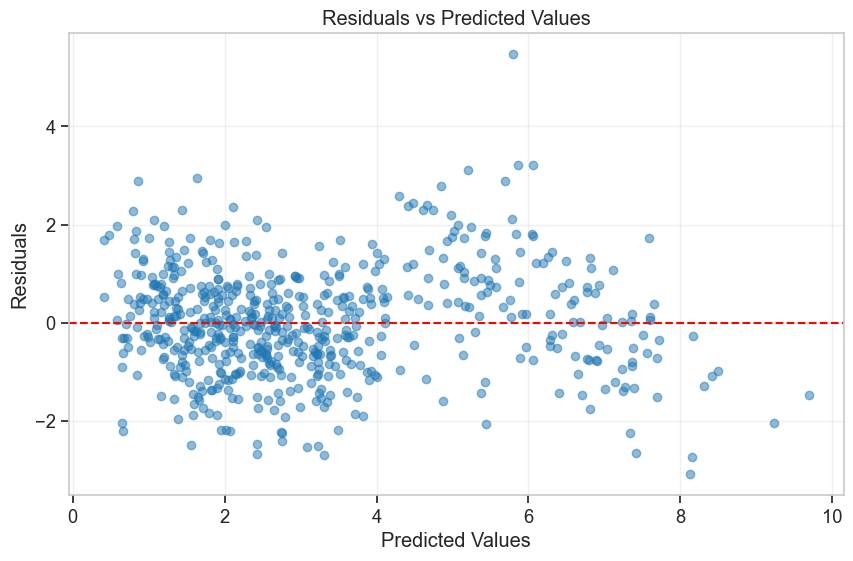

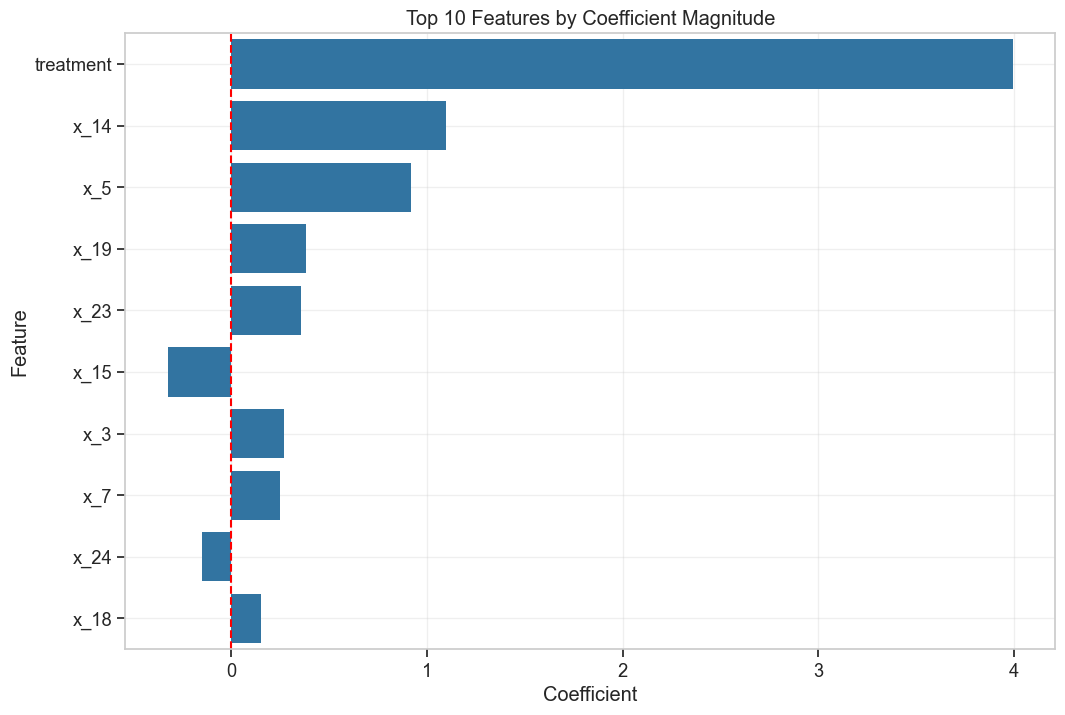

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def regression_adjustment(X, T, Y):
    """
    Estimate ATE using regression adjustment
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    
    Returns:
    --------
    ate : Estimated average treatment effect
    model : Fitted model
    """
    # Create dataframe with treatment and covariates
    data = X.copy()
    data['treatment'] = T
    
    # Fit the model
    model = LinearRegression()
    model.fit(data, Y)
    
    # Get the treatment coefficient
    treatment_idx = data.columns.get_loc('treatment')
    ate = model.coef_[treatment_idx]
    
    return ate, model

# Estimate ATE using regression adjustment
reg_ate_train, reg_model = regression_adjustment(X_train_scaled, T_train, Y_train)

print(f"Regression adjustment ATE estimate: {reg_ate_train:.4f}")
print(f"True ATE (training): {true_ate_train:.4f}")
print(f"Bias: {reg_ate_train - true_ate_train:.4f}")

# Assess model fit
y_pred = reg_model.predict(pd.concat([X_train_scaled, pd.Series(T_train, name='treatment')], axis=1))
mse = mean_squared_error(Y_train, y_pred)
r2 = r2_score(Y_train, y_pred)

print(f"Model MSE: {mse:.4f}")
print(f"Model R²: {r2:.4f}")

# Visualize residuals
residuals = Y_train - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

# Plot feature importance
coef_df = pd.DataFrame({
    'Feature': list(X_train_scaled.columns) + ['treatment'],
    'Coefficient': list(reg_model.coef_)
})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title('Top 10 Features by Coefficient Magnitude')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

**Analysis:** The regression adjustment method estimates the treatment effect by including the treatment indicator and covariates in a regression model. The coefficient of the treatment variable represents the estimated ATE. This method reduces bias compared to the naive approach because it controls for observed confounders.

The residual plot helps us assess the model fit. Ideally, the residuals should be randomly scattered around zero with no clear pattern. Any pattern might indicate model misspecification.

The feature importance plot shows which covariates have the strongest association with the outcome. This gives us insights into which variables are important predictors and potentially important confounders.

#### 4.2.3 Stratification by Covariate

Another simple approach is to stratify the data by important covariates and estimate the treatment effect within each stratum.

Stratified ATE estimate (by birth weight): 4.0719
True ATE (training): 3.9871
Bias: 0.0847
Stratified ATE estimate (by mother's education): 4.0383
Bias: 0.0511


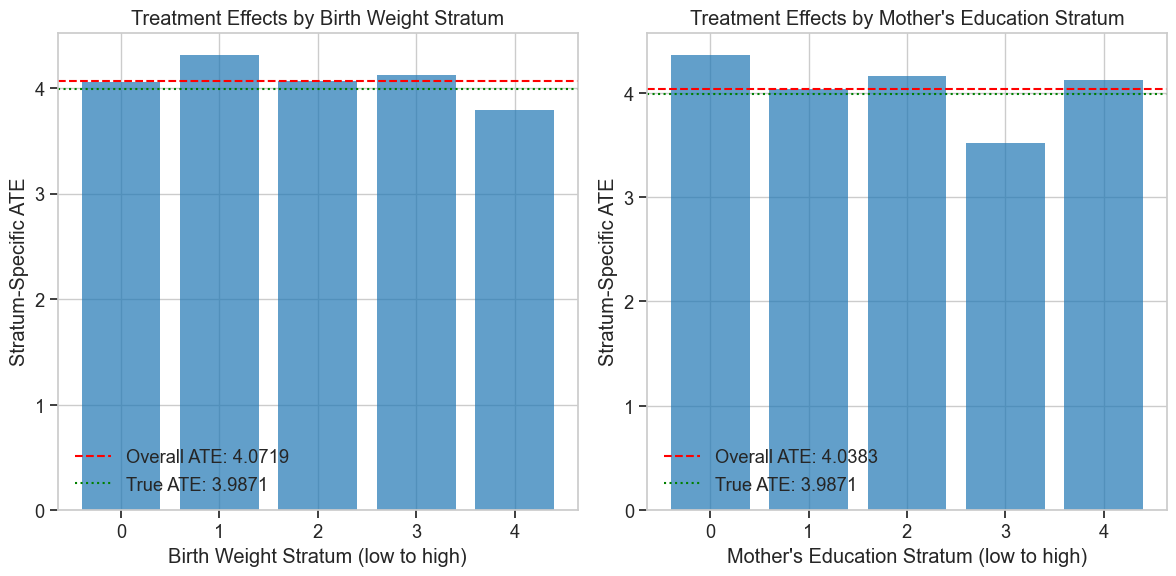

In [5]:
def stratified_estimator(X, T, Y, stratify_var, n_bins=5):
    """
    Estimate ATE by stratifying on a continuous covariate
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    stratify_var : str, Name of variable to stratify on
    n_bins : int, Number of bins for stratification
    
    Returns:
    --------
    ate : Estimated average treatment effect
    """
    # Create bins for the stratification variable
    data = pd.DataFrame({
        'X': X[stratify_var],
        'T': T,
        'Y': Y
    })
    
    data['bin'] = pd.qcut(data['X'], n_bins, labels=False)
    
    # Calculate stratified ATE
    stratum_effects = []
    stratum_sizes = []
    
    for bin_idx in range(n_bins):
        bin_data = data[data['bin'] == bin_idx]
        if (bin_data['T'] == 1).sum() > 0 and (bin_data['T'] == 0).sum() > 0:
            treated_mean = bin_data[bin_data['T'] == 1]['Y'].mean()
            control_mean = bin_data[bin_data['T'] == 0]['Y'].mean()
            effect = treated_mean - control_mean
            stratum_effects.append(effect)
            stratum_sizes.append(len(bin_data))
    
    # Weight by stratum size
    if stratum_effects:
        weighted_ate = sum(effect * size for effect, size in zip(stratum_effects, stratum_sizes)) / sum(stratum_sizes)
        return weighted_ate, stratum_effects, stratum_sizes
    else:
        return np.nan, [], []

# Choose an important continuous covariate for stratification
# We'll use birth weight (x_0) as it's likely an important confounder
stratified_ate, stratum_effects, stratum_sizes = stratified_estimator(X_train, T_train, Y_train, 'x_0', n_bins=5)

print(f"Stratified ATE estimate (by birth weight): {stratified_ate:.4f}")
print(f"True ATE (training): {true_ate_train:.4f}")
print(f"Bias: {stratified_ate - true_ate_train:.4f}")

# Try stratifying by another variable (mother's education)
stratified_ate2, stratum_effects2, stratum_sizes2 = stratified_estimator(X_train, T_train, Y_train, 'x_4', n_bins=5)

print(f"Stratified ATE estimate (by mother's education): {stratified_ate2:.4f}")
print(f"Bias: {stratified_ate2 - true_ate_train:.4f}")

# Visualize the stratum-specific effects
plt.figure(figsize=(12, 6))

# Plot 1: Effects by birth weight stratum
plt.subplot(1, 2, 1)
plt.bar(range(len(stratum_effects)), stratum_effects, alpha=0.7)
plt.axhline(y=stratified_ate, color='red', linestyle='--', label=f'Overall ATE: {stratified_ate:.4f}')
plt.axhline(y=true_ate_train, color='green', linestyle=':', label=f'True ATE: {true_ate_train:.4f}')
plt.title('Treatment Effects by Birth Weight Stratum')
plt.xlabel('Birth Weight Stratum (low to high)')
plt.ylabel('Stratum-Specific ATE')
plt.legend()

# Plot 2: Effects by mother's education stratum
plt.subplot(1, 2, 2)
plt.bar(range(len(stratum_effects2)), stratum_effects2, alpha=0.7)
plt.axhline(y=stratified_ate2, color='red', linestyle='--', label=f'Overall ATE: {stratified_ate2:.4f}')
plt.axhline(y=true_ate_train, color='green', linestyle=':', label=f'True ATE: {true_ate_train:.4f}')
plt.title('Treatment Effects by Mother\'s Education Stratum')
plt.xlabel('Mother\'s Education Stratum (low to high)')
plt.ylabel('Stratum-Specific ATE')
plt.legend()

plt.tight_layout()
plt.show()

**Analysis:** Stratification divides the data into subgroups based on an important covariate and estimates the treatment effect within each subgroup. The overall estimate is a weighted average of these stratum-specific effects. This method helps account for the confounding effect of the stratification variable but doesn't adjust for other confounders.

The visualizations show how the treatment effect varies across different strata of birth weight and mother's education. This heterogeneity suggests that the treatment effect might depend on these covariates, which is valuable information for targeted interventions.

#### 4.2.4 Comparing Simple Methods

Let's compare the performance of these simple methods:

Comparison of Simple Methods:
                                Method  ATE Estimate  True ATE      Bias  \
1                Regression Adjustment      3.996965  3.987137  0.009828   
3  Stratification (Mother's Education)      4.038255  3.987137  0.051118   
0                Naive Mean Difference      4.053924  3.987137  0.066787   
2        Stratification (Birth Weight)      4.071883  3.987137  0.084746   

   Absolute Bias  
1       0.009828  
3       0.051118  
0       0.066787  
2       0.084746  


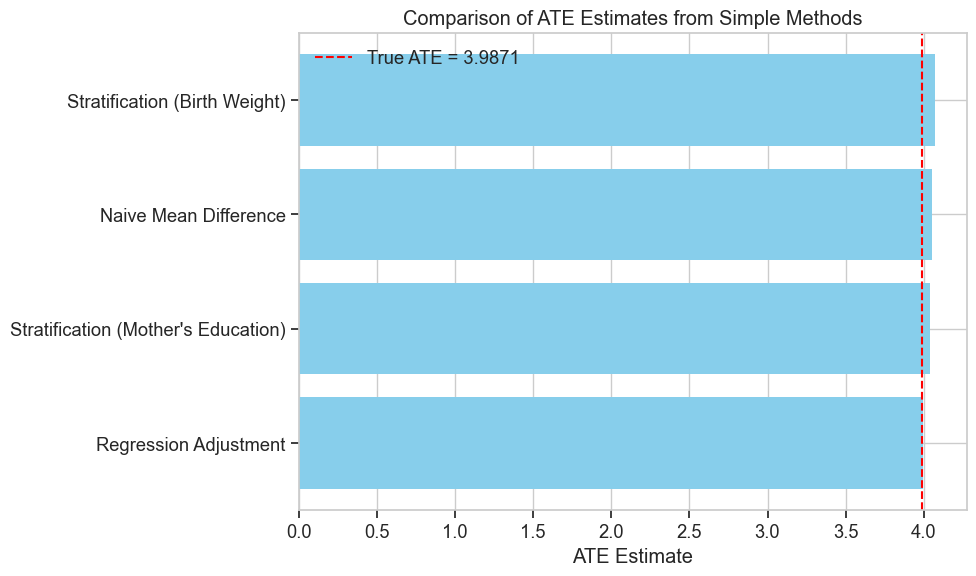

In [6]:
# Compile results from simple methods
simple_methods = pd.DataFrame({
    'Method': ['Naive Mean Difference', 'Regression Adjustment', 
               'Stratification (Birth Weight)', 'Stratification (Mother\'s Education)'],
    'ATE Estimate': [naive_ate_train, reg_ate_train, stratified_ate, stratified_ate2],
    'True ATE': [true_ate_train] * 4,
    'Bias': [naive_ate_train - true_ate_train, 
             reg_ate_train - true_ate_train, 
             stratified_ate - true_ate_train, 
             stratified_ate2 - true_ate_train],
    'Absolute Bias': [abs(naive_ate_train - true_ate_train), 
                     abs(reg_ate_train - true_ate_train), 
                     abs(stratified_ate - true_ate_train), 
                     abs(stratified_ate2 - true_ate_train)]
})

# Sort by absolute bias
simple_methods = simple_methods.sort_values('Absolute Bias')
print("Comparison of Simple Methods:")
print(simple_methods)

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.barh(y=simple_methods['Method'], width=simple_methods['ATE Estimate'], color='skyblue')
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')
plt.xlabel('ATE Estimate')
plt.title('Comparison of ATE Estimates from Simple Methods')
plt.legend()
plt.tight_layout()
plt.show()

**Analysis:** This comparison helps us understand how different simple methods perform in estimating the causal effect. Methods with lower bias provide estimates closer to the true ATE. The visualization makes it easy to see which methods are most accurate.

These simple methods provide a foundation for understanding causal inference. However, they have limitations, especially when dealing with complex confounding. In the next section, we'll explore more advanced methods that can provide more robust causal estimates.

#### References and Resources

- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences. Cambridge University Press.
- [Causal Inference in Python: Simple Methods](https://matheusfacure.github.io/python-causality-handbook/03-Stats-Tools-for-Causal-Inference.html)
- [Introduction to Causal Inference: Regression Adjustment](https://www.bradyneal.com/causal-inference-course)


# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.3.1

### 4.3 Propensity Score Methods

> 🎯 **Step 3**: Implement propensity score-based methods for causal inference

Propensity score methods estimate the probability of receiving treatment given covariates, then use these scores to adjust for confounding.

#### 4.3.1 Estimating Propensity Scores

Propensity Score Model Evaluation:
Logistic Regression: AUC = 0.7541, Log Loss = 0.4200, Brier Score = 0.1348
Random Forest: AUC = 0.9127, Log Loss = 0.3761, Brier Score = 0.1179


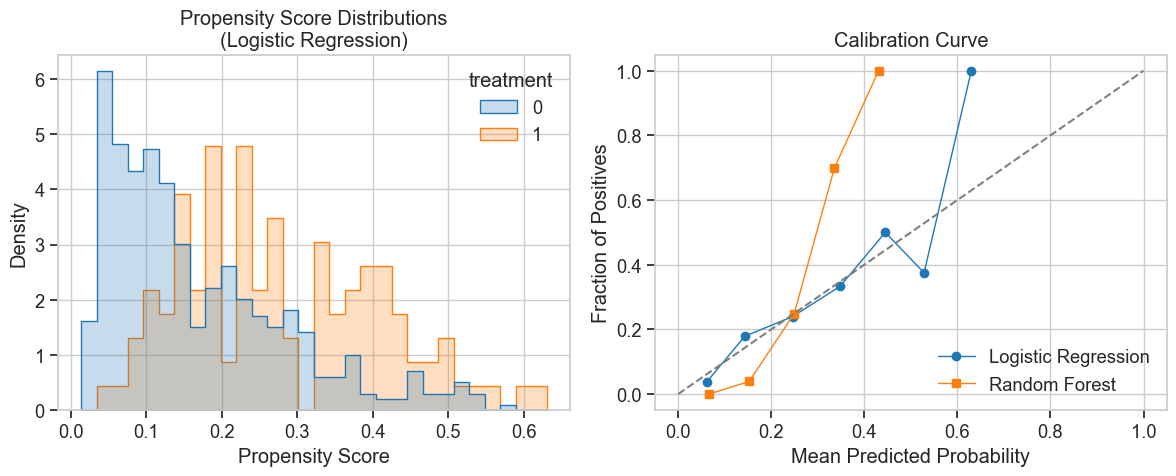

Checking overlap for logistic regression propensity scores:
Common support region: [0.0493, 0.5746]
Percentage of units in common support: 89.26%
Percentage of units with extreme propensity scores: 10.74%
Checking overlap for random forest propensity scores:
Common support region: [0.1481, 0.3755]
Percentage of units in common support: 60.91%
Percentage of units with extreme propensity scores: 5.20%


In [7]:
# Assuming the imports and data preparation from previous sections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, brier_score_loss

# Estimate propensity scores using different methods
def estimate_propensity_scores(X, T, method='logistic'):
    """
    Estimate propensity scores using various methods
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    method : str, Method to use ('logistic' or 'rf')
    
    Returns:
    --------
    ps : Series of propensity scores
    model : Fitted model
    """
    if method == 'logistic':
        model = LogisticRegression(max_iter=1000, C=1.0)
    elif method == 'rf':
        model = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=42)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    model.fit(X, T)
    ps = model.predict_proba(X)[:, 1]
    return ps, model

# Estimate propensity scores for both methods
ps_logistic_train, ps_model_logistic = estimate_propensity_scores(X_train_scaled, T_train, 'logistic')
ps_rf_train, ps_model_rf = estimate_propensity_scores(X_train_scaled, T_train, 'rf')

# Add propensity scores to our data
train_data = X_train_scaled.copy()
train_data['treatment'] = T_train
train_data['outcome'] = Y_train
train_data['ps_logistic'] = ps_logistic_train
train_data['ps_rf'] = ps_rf_train

# Evaluate propensity score models
print("Propensity Score Model Evaluation:")
for name, ps in [('Logistic Regression', ps_logistic_train), ('Random Forest', ps_rf_train)]:
    auc = roc_auc_score(T_train, ps)
    ll = log_loss(T_train, ps)
    bs = brier_score_loss(T_train, ps)
    print(f"{name}: AUC = {auc:.4f}, Log Loss = {ll:.4f}, Brier Score = {bs:.4f}")

# Plot propensity score distributions
plt.figure(figsize=(12, 5))

# Plot 1: Propensity score distributions by treatment group
plt.subplot(1, 2, 1)
sns.histplot(data=train_data, x='ps_logistic', hue='treatment', bins=30, 
            element="step", common_norm=False, stat='density')
plt.title('Propensity Score Distributions\n(Logistic Regression)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')

# Plot 2: Calibration curve
plt.subplot(1, 2, 2)
prob_true, prob_pred = calibration_curve(T_train, ps_logistic_train, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')

prob_true_rf, prob_pred_rf = calibration_curve(T_train, ps_rf_train, n_bins=10)
plt.plot(prob_pred_rf, prob_true_rf, marker='s', linewidth=1, label='Random Forest')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()

plt.tight_layout()
plt.show()

# Check for overlap/positivity assumption
def check_overlap(ps, T):
    """Check overlap assumption and trim propensity scores if needed"""
    # Calculate min and max propensity scores for treated and control
    treated_min = ps[T == 1].min()
    treated_max = ps[T == 1].max()
    control_min = ps[T == 0].min()
    control_max = ps[T == 0].max()
    
    # Find common support region
    common_min = max(treated_min, control_min)
    common_max = min(treated_max, control_max)
    
    # Calculate percentage of units in common support
    in_support = (ps >= common_min) & (ps <= common_max)
    pct_in_support = in_support.mean() * 100
    
    # Check for extreme propensity scores
    extreme_ps = (ps < 0.05) | (ps > 0.95)
    pct_extreme = extreme_ps.mean() * 100
    
    print(f"Common support region: [{common_min:.4f}, {common_max:.4f}]")
    print(f"Percentage of units in common support: {pct_in_support:.2f}%")
    print(f"Percentage of units with extreme propensity scores: {pct_extreme:.2f}%")
    
    return common_min, common_max, in_support

# Check overlap for logistic regression propensity scores
print("Checking overlap for logistic regression propensity scores:")
common_min, common_max, in_support_logistic = check_overlap(ps_logistic_train, T_train)

# Check overlap for random forest propensity scores
print("Checking overlap for random forest propensity scores:")
common_min_rf, common_max_rf, in_support_rf = check_overlap(ps_rf_train, T_train)

**Analysis:** Propensity score estimation is crucial for propensity score-based methods. We've used both logistic regression and random forest models to estimate the probability of treatment given covariates.

The propensity score distributions show how treatment probability varies between treated and control groups. Ideally, these distributions should overlap substantially, indicating that each unit has a non-zero probability of receiving either treatment (the positivity assumption).

The calibration curves show how well the predicted probabilities match the observed frequencies. Points closer to the diagonal represent better calibration. Well-calibrated propensity scores are important for methods like inverse probability weighting.

The overlap check helps identify regions of common support and extreme propensity scores. Units with very high or very low propensity scores may need special attention in the analysis.

Let's examine feature importance in the propensity score model:

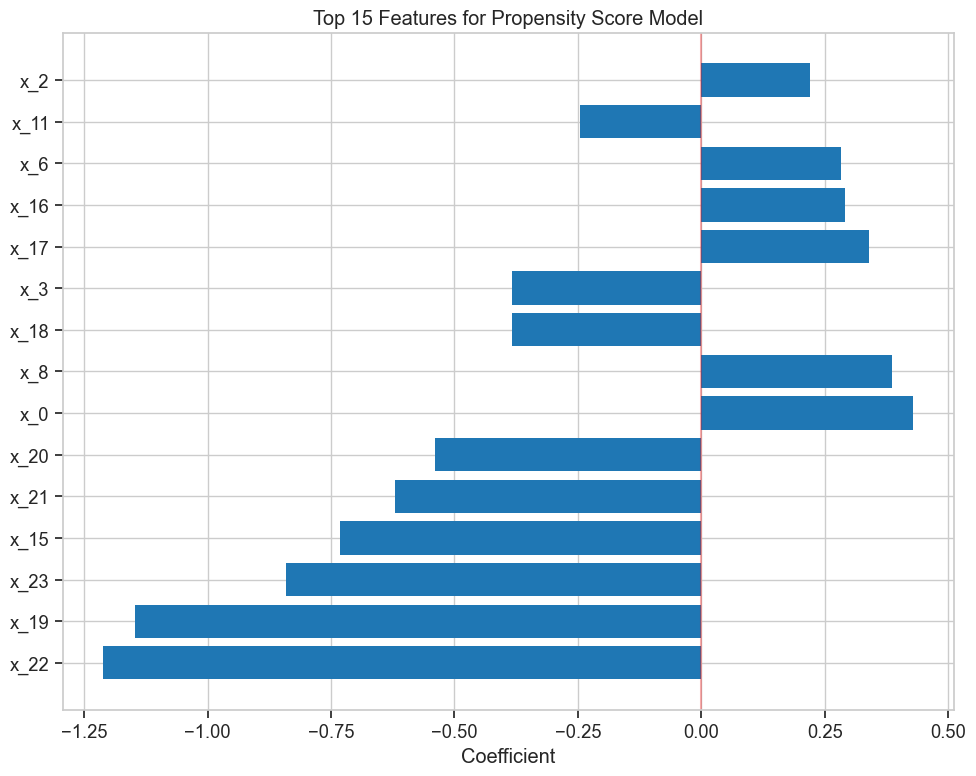

In [8]:
# Visualize important features for propensity score model
if hasattr(ps_model_logistic, 'coef_'):
    # For logistic regression, we can directly extract coefficients
    coef = ps_model_logistic.coef_[0]
    features = X_train_scaled.columns
    
    # Create DataFrame for visualization
    ps_coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': coef,
        'Abs_Coefficient': np.abs(coef)
    })
    
    # Sort by absolute coefficient
    ps_coef_df = ps_coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(10, 8))
    plt.barh(y=ps_coef_df['Feature'].head(15), width=ps_coef_df['Coefficient'].head(15))
    plt.axvline(x=0, color='red', linestyle='-', alpha=0.3)
    plt.title('Top 15 Features for Propensity Score Model')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.show()

**Analysis:** The feature importance plot shows which covariates are most predictive of treatment assignment. Features with larger coefficients have a stronger influence on the propensity score. Understanding these relationships is valuable for interpreting the selection mechanism and potential confounding.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.3.2

#### 4.3.2 Inverse Probability Weighting (IPW)

IPW creates a pseudo-population where treatment assignment is independent of covariates by weighting observations inversely to their propensity scores.

IPW Estimation Results:
  PS Method  Stabilized  Trimming       ATE      Bias  Abs Bias  Max Weight  \
4        RF        True       NaN  4.022956  0.035819  0.035819    1.300351   
6        RF       False       NaN  4.022956  0.035819  0.035819    6.753253   
5        RF        True      95.0  4.027181  0.040044  0.040044    1.146362   
3  Logistic       False      95.0  4.042309  0.055172  0.055172    5.378610   
1  Logistic        True      95.0  4.053295  0.066158  0.066158    1.483660   
7        RF       False      95.0  4.055651  0.068514  0.068514    3.643779   
0  Logistic        True       NaN  4.062421  0.075284  0.075284    3.814291   
2  Logistic       False       NaN  4.062421  0.075284  0.075284   20.297479   

   Weight SD  
4   0.171678  
6   0.968897  
5   0.166927  
3   1.191268  
1   0.226848  
7   0.803667  
0   0.290109  
2   1.840260  

Best IPW Method:
PS Method: RF
Stabilized: True
Trimming: nan
ATE: 4.0230
Bias: 0.0358


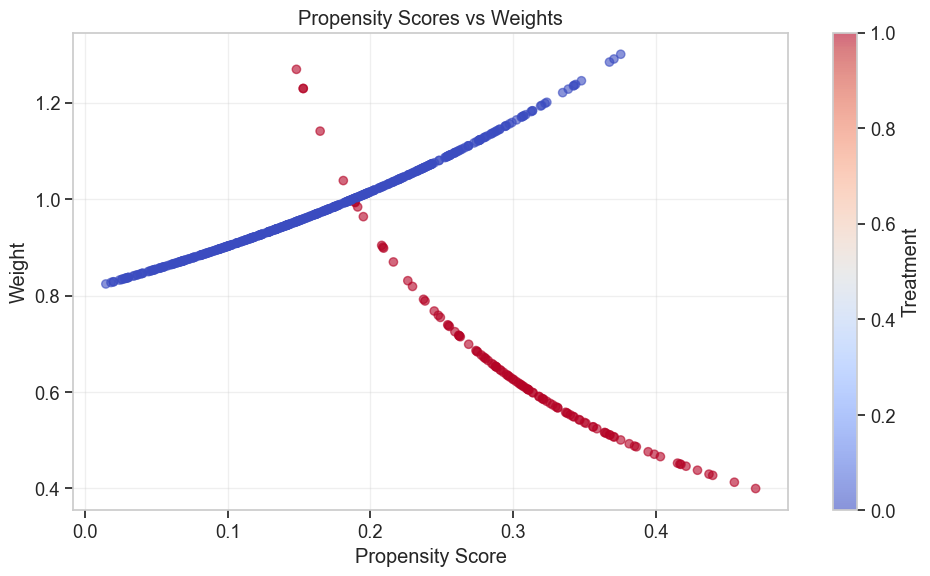

<Figure size 1200x1000 with 0 Axes>

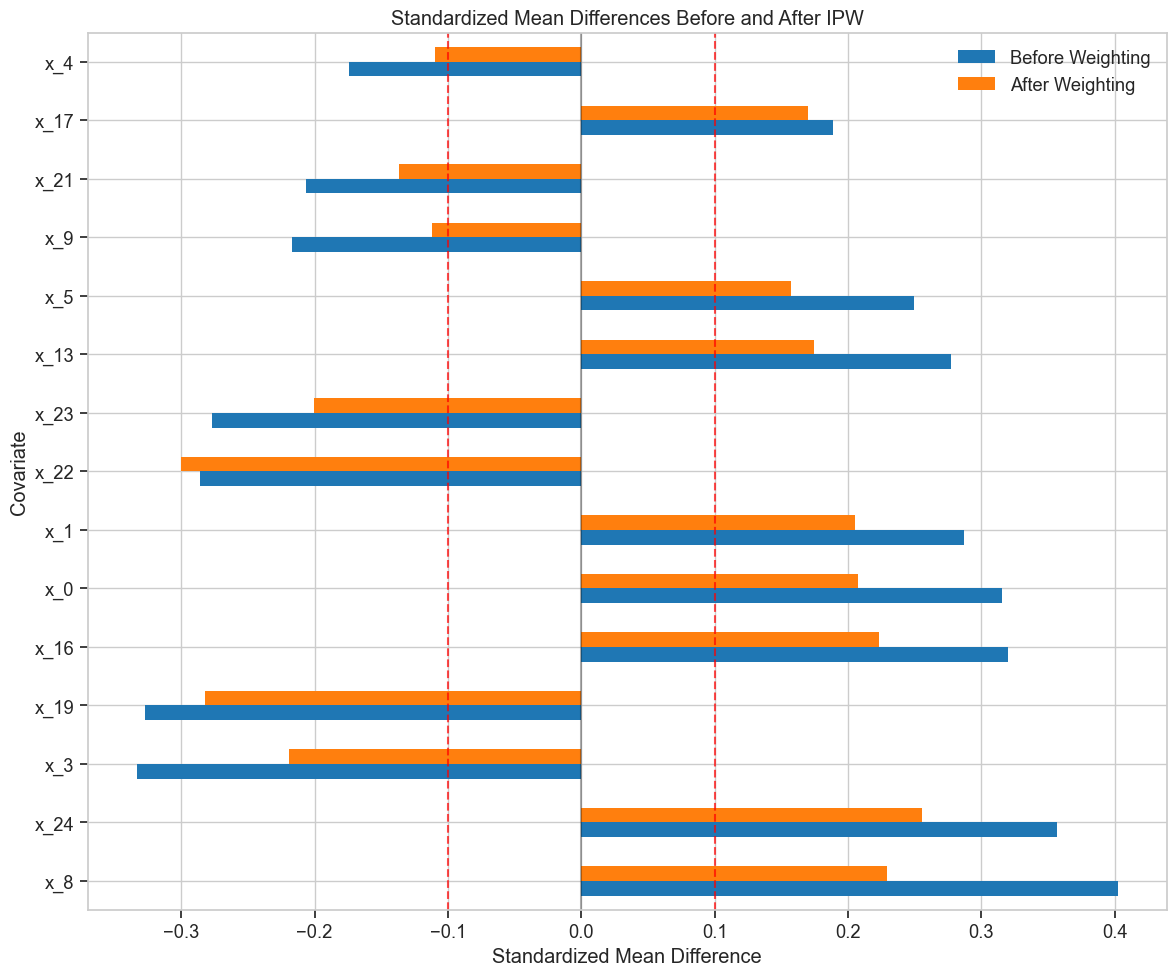

In [17]:
def ipw_estimator(T, Y, ps, stabilized=True, trimming=None):
    """
    Estimate ATE using inverse probability weighting
    
    Parameters:
    -----------
    T : Series of treatment assignments
    Y : Series of outcomes
    ps : Series of propensity scores
    stabilized : bool, Whether to use stabilized weights
    trimming : float or None, Percentile for trimming extreme weights (must be between 0 and 100)
    
    Returns:
    --------
    ate : Estimated average treatment effect
    weights : Series of weights
    """
    # Calculate IPW weights
    if stabilized:
        # Stabilized weights
        p_treatment = T.mean()
        weights = np.where(T == 1, p_treatment / ps, (1 - p_treatment) / (1 - ps))
    else:
        # Unstabilized weights
        weights = np.where(T == 1, 1 / ps, 1 / (1 - ps))
    
    # Trim weights if requested
    if trimming is not None:
        # Check if trimming is already a float/int (not a string representation)
        try:
            trimming_val = float(trimming)
            # Ensure trimming is between 0 and 100
            if not (0 <= trimming_val <= 100):
                # Probably using a misunderstood convention - adjust value
                print(f"Warning: Trimming value {trimming_val} outside [0,100] range. Assuming it's in percent notation.")
                trimming_val = min(max(trimming_val, 0), 100)
            max_weight = np.percentile(weights, trimming_val)
            weights = np.minimum(weights, max_weight)
        except (ValueError, TypeError):
            # If trimming isn't a valid number, skip trimming
            print(f"Warning: Invalid trimming value {trimming}. Skipping weight trimming.")
    
    # Calculate weighted means
    weighted_treated = np.sum(weights[T == 1] * Y[T == 1]) / np.sum(weights[T == 1])
    weighted_control = np.sum(weights[T == 0] * Y[T == 0]) / np.sum(weights[T == 0])
    
    # Calculate ATE
    ate = weighted_treated - weighted_control
    
    return ate, weights
# Estimate ATE using IPW with different settings
ipw_results = []

for ps_method, ps_values in [('Logistic', ps_logistic_train), ('RF', ps_rf_train)]:
    for stabilized in [True, False]:
        for trimming in [None, 95]:
            # Calculate IPW estimate
            ipw_ate, weights = ipw_estimator(T_train, Y_train, ps_values, 
                                             stabilized=stabilized, trimming=trimming)
            
            # Save result
            ipw_results.append({
                'PS Method': ps_method,
                'Stabilized': stabilized,
                'Trimming': trimming,
                'ATE': ipw_ate,
                'Bias': ipw_ate - true_ate_train,
                'Abs Bias': abs(ipw_ate - true_ate_train),
                'Max Weight': np.max(weights),
                'Weight SD': np.std(weights)
            })

# Convert to DataFrame for easier visualization
ipw_results_df = pd.DataFrame(ipw_results)
print("IPW Estimation Results:")
print(ipw_results_df.sort_values('Abs Bias'))

# Find best IPW method
best_ipw_idx = ipw_results_df['Abs Bias'].idxmin()
best_ipw = ipw_results_df.loc[best_ipw_idx]
print(f"\nBest IPW Method:")
print(f"PS Method: {best_ipw['PS Method']}")
print(f"Stabilized: {best_ipw['Stabilized']}")
print(f"Trimming: {best_ipw['Trimming']}")
print(f"ATE: {best_ipw['ATE']:.4f}")
print(f"Bias: {best_ipw['Bias']:.4f}")

# Visualize the weights
best_ps = ps_rf_train if best_ipw['PS Method'] == 'RF' else ps_logistic_train
_, best_weights = ipw_estimator(T_train, Y_train, best_ps, 
                              stabilized=best_ipw['Stabilized'], 
                              trimming=best_ipw['Trimming'])

plt.figure(figsize=(10, 6))
plt.scatter(best_ps, best_weights, alpha=0.6, c=T_train, cmap='coolwarm')
plt.title('Propensity Scores vs Weights')
plt.xlabel('Propensity Score')
plt.ylabel('Weight')
plt.colorbar(label='Treatment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Assess covariate balance after IPW
def assess_balance(X, T, weights=None):
   """
   Assess covariate balance before and after weighting
   
   Parameters:
   -----------
   X : DataFrame of covariates
   T : Series of treatment assignments
   weights : Series of weights or None
   
   Returns:
   --------
   balance_df : DataFrame with standardized mean differences
   """
   # Calculate standardized mean differences
   balance_stats = []
   
   for col in X.columns:
       # Unweighted means and std devs
       treated_mean = X.loc[T == 1, col].mean()
       control_mean = X.loc[T == 0, col].mean()
       treated_std = X.loc[T == 1, col].std()
       control_std = X.loc[T == 0, col].std()
       
       # Calculate pooled standard deviation
       pooled_std = np.sqrt((treated_std**2 + control_std**2) / 2)
       
       # Calculate standardized mean difference (SMD)
       if pooled_std == 0:
           smd_before = 0
       else:
           smd_before = (treated_mean - control_mean) / pooled_std
       
       # If weights are provided, calculate weighted means and std devs
       if weights is not None:
           # Calculate weighted means with safety checks
           treated_weights = weights[T == 1]
           control_weights = weights[T == 0]
           
           # Safe calculation of weighted means
           if np.sum(treated_weights) > 0:
               treated_weighted_mean = np.average(X.loc[T == 1, col], weights=treated_weights)
           else:
               treated_weighted_mean = treated_mean  # Fall back to unweighted mean
           
           if np.sum(control_weights) > 0:
               control_weighted_mean = np.average(X.loc[T == 0, col], weights=control_weights)
           else:
               control_weighted_mean = control_mean  # Fall back to unweighted mean
           
           # Safe calculation of weighted std devs
           if np.sum(treated_weights) > 0:
               try:
                   treated_weighted_std = np.sqrt(np.average((X.loc[T == 1, col] - treated_weighted_mean)**2, 
                                                            weights=treated_weights))
               except ZeroDivisionError:
                   treated_weighted_std = treated_std  # Fall back to unweighted std
           else:
               treated_weighted_std = treated_std
           
           if np.sum(control_weights) > 0:
               try:
                   control_weighted_std = np.sqrt(np.average((X.loc[T == 0, col] - control_weighted_mean)**2, 
                                                            weights=control_weights))
               except ZeroDivisionError:
                   control_weighted_std = control_std  # Fall back to unweighted std
           else:
               control_weighted_std = control_std
           
           # Calculate weighted pooled standard deviation
           weighted_pooled_std = np.sqrt((treated_weighted_std**2 + control_weighted_std**2) / 2)
           
           # Calculate weighted SMD
           if weighted_pooled_std == 0:
               smd_after = 0
           else:
               smd_after = (treated_weighted_mean - control_weighted_mean) / weighted_pooled_std
       else:
           smd_after = None
       
       # Add to balance stats
       balance_stats.append({
           'Variable': col,
           'SMD_Before': smd_before,
           'SMD_After': smd_after,
           'Mean_Diff_Before': treated_mean - control_mean
       })
   
   # Convert to DataFrame
   balance_df = pd.DataFrame(balance_stats)
   
   # Sort by absolute SMD before weighting
   balance_df = balance_df.sort_values('SMD_Before', key=abs, ascending=False)
   
   return balance_df
# Assess balance before and after IPW
balance_df = assess_balance(X_train_scaled, T_train, best_weights)

# Plot balance before and after weighting
plt.figure(figsize=(12, 10))
variables = balance_df['Variable'].head(15)  # Top 15 variables by initial imbalance

# Create plot
balance_plot = pd.DataFrame({
    'Before Weighting': balance_df.loc[balance_df['Variable'].isin(variables), 'SMD_Before'],
    'After Weighting': balance_df.loc[balance_df['Variable'].isin(variables), 'SMD_After']
})
balance_plot.index = variables

balance_plot.plot(kind='barh', figsize=(12, 10))
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=-0.1, color='red', linestyle='--', alpha=0.7)
plt.title('Standardized Mean Differences Before and After IPW')
plt.xlabel('Standardized Mean Difference')
plt.ylabel('Covariate')
plt.tight_layout()
plt.show()

**Analysis:** Inverse Probability Weighting (IPW) creates a pseudo-population where the distribution of covariates is balanced between treatment groups. This is achieved by weighting each observation inversely to its probability of receiving the treatment it actually received.

Key options in IPW:
1. **Stabilized weights**: Multiply by the marginal probability of treatment to reduce variance
2. **Weight trimming**: Truncate extreme weights to prevent a few observations from dominating

The weights vs. propensity scores plot illustrates how units with propensity scores close to 0 or 1 receive higher weights. This can lead to instability if there are units with very extreme propensity scores.

The balance plot shows standardized mean differences (SMDs) before and after weighting. SMDs closer to zero indicate better balance. Values within the red dashed lines (±0.1) are generally considered acceptable. IPW should improve balance across most or all covariates.

The best IPW method is selected based on the smallest absolute bias compared to the true ATE. In practice, where the true effect is unknown, we would rely on theoretical properties of the methods and covariate balance assessments.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.3.3

#### 4.3.3 Propensity Score Matching

Propensity score matching pairs treated units with control units having similar propensity scores.

Propensity Score Matching Results:
  PS Method  k  Caliper       ATE      Bias  Abs Bias  Matches
2  Logistic  5      0.2  3.960687 -0.026450  0.026450      546
5        RF  5      0.2  3.958562 -0.028575  0.028575      480
4        RF  1      0.2  3.941401 -0.045736  0.045736      100
3        RF  1      NaN  4.052310  0.065173  0.065173      112
0  Logistic  1      NaN  4.151229  0.164092  0.164092      112
1  Logistic  1      0.2  4.168739  0.181602  0.181602      111

Best Matching Method:
PS Method: Logistic
k: 5
Caliper: 0.2
ATE: 3.9607
Bias: -0.0265
Number of matches: 546


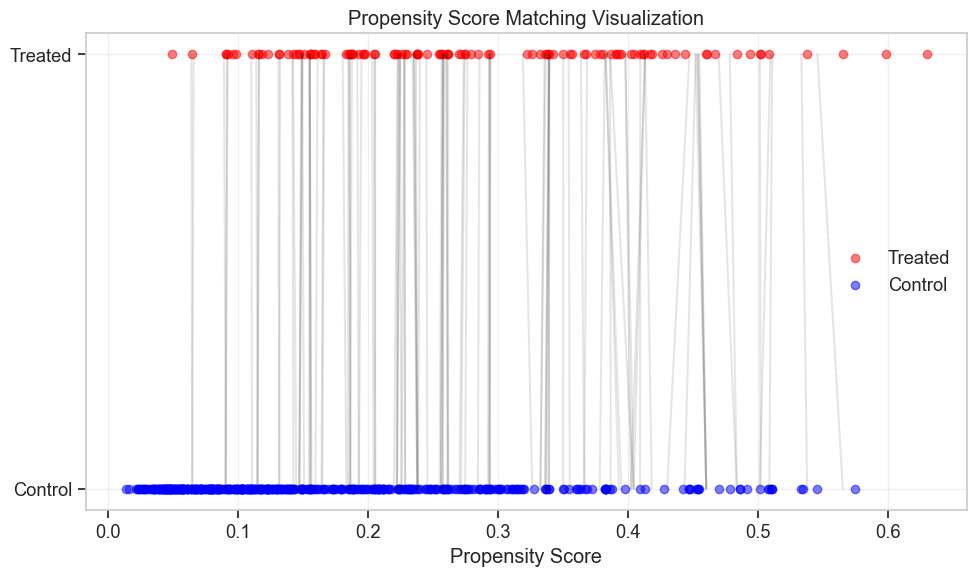

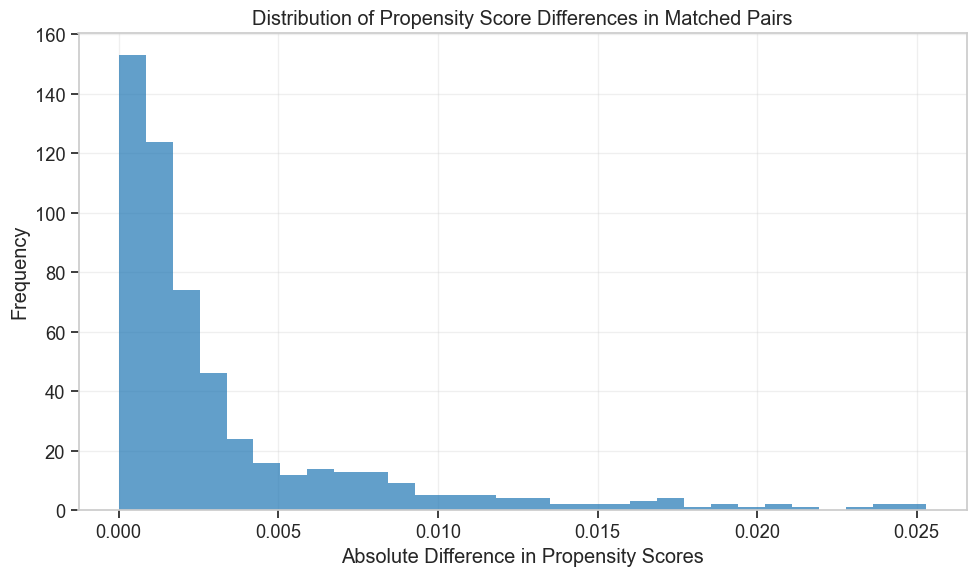

<Figure size 1200x1000 with 0 Axes>

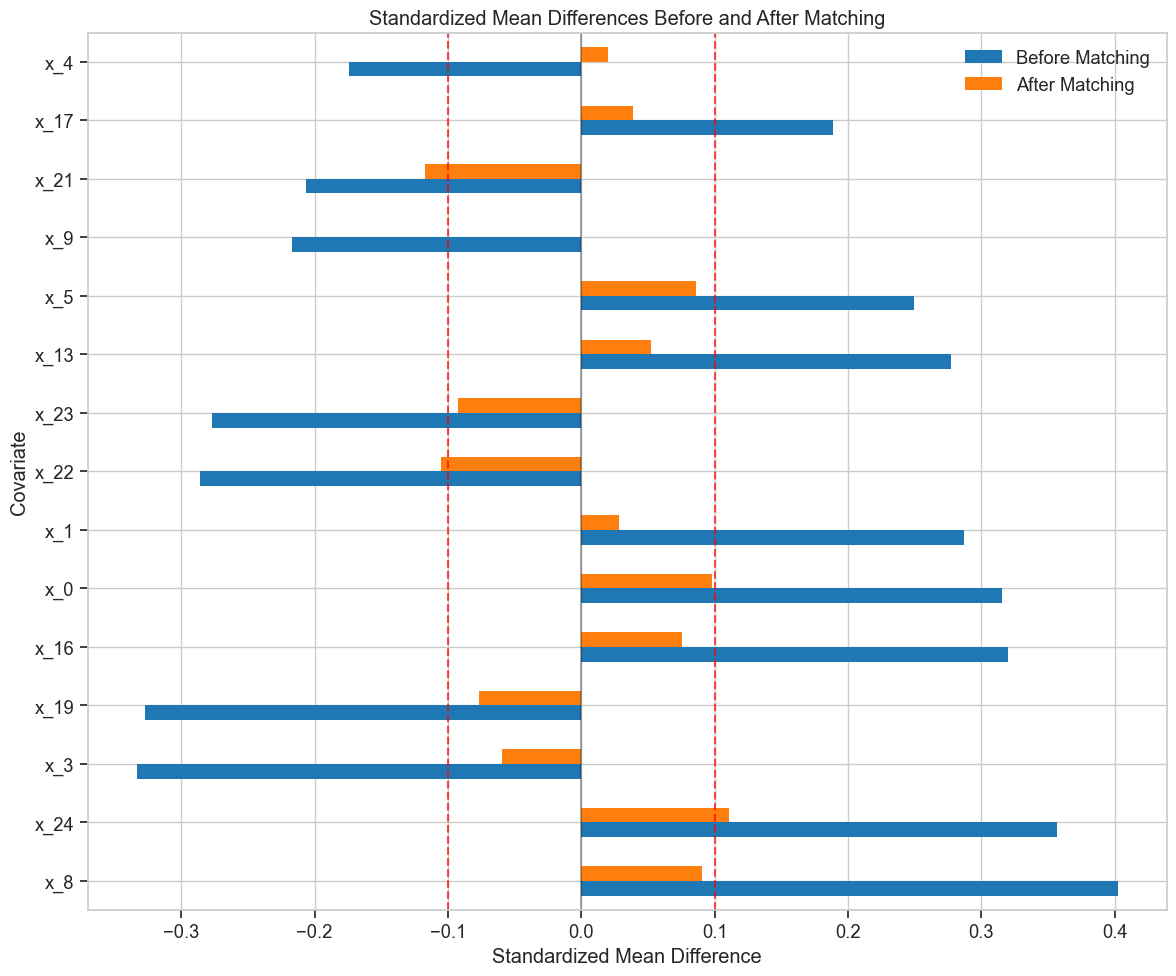

In [18]:
from sklearn.neighbors import NearestNeighbors

def ps_matching_estimator(X, T, Y, ps, method='nearest', k=1, caliper=None):
    """
    Estimate ATE using propensity score matching
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    ps : Series of propensity scores
    method : str, Matching method ('nearest' or 'caliper')
    k : int, Number of matches
    caliper : float or None, Caliper width (in standard deviations)
    
    Returns:
    --------
    ate : Estimated average treatment effect
    matched_data : DataFrame of matched data
    """
    # Create a dataframe with all necessary info
    data = pd.DataFrame({
        'treatment': T,
        'outcome': Y,
        'ps': ps
    })
    
    # Add covariates
    for col in X.columns:
        data[col] = X[col]
    
    # Separate treated and control
    treated = data[data['treatment'] == 1]
    control = data[data['treatment'] == 0]
    
    # Prepare for matching
    treated_ps = treated['ps'].values.reshape(-1, 1)
    control_ps = control['ps'].values.reshape(-1, 1)
    
    if method == 'nearest':
        # Nearest neighbor matching
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(control_ps)
        distances, indices = nn.kneighbors(treated_ps)
        
        # For each treated unit, find its matches
        matched_pairs = []
        
        for i, treated_idx in enumerate(treated.index):
            for j in range(k):
                control_idx = control.index[indices[i, j]]
                dist = distances[i, j]
                
                if caliper is None or dist < caliper * np.std(data['ps']):
                    matched_pairs.append({
                        'treated_idx': treated_idx,
                        'control_idx': control_idx,
                        'treated_ps': treated.loc[treated_idx, 'ps'],
                        'control_ps': control.loc[control_idx, 'ps'],
                        'treated_outcome': treated.loc[treated_idx, 'outcome'],
                        'control_outcome': control.loc[control_idx, 'outcome'],
                        'ps_diff': abs(treated.loc[treated_idx, 'ps'] - control.loc[control_idx, 'ps'])
                    })
        
        # Create dataframe of matched pairs
        matched_df = pd.DataFrame(matched_pairs)
        
        if matched_df.empty:
            print("No matches found with current settings")
            return np.nan, None
        
        # Calculate treatment effect
        ate = (matched_df['treated_outcome'] - matched_df['control_outcome']).mean()
        
        return ate, matched_df
    
    else:
        raise ValueError(f"Unknown matching method: {method}")

# Perform propensity score matching with different settings
matching_results = []

for ps_method, ps_values in [('Logistic', ps_logistic_train), ('RF', ps_rf_train)]:
    for k in [1, 5]:
        for caliper in [None, 0.2]:
            # Skip if not using a caliper with multiple neighbors
            if k > 1 and caliper is None:
                continue
                
            # Calculate matching estimate
            psm_ate, matched_data = ps_matching_estimator(
                X_train_scaled, T_train, Y_train, ps_values, 
                method='nearest', k=k, caliper=caliper
            )
            
            if matched_data is not None:
                # Save result
                matching_results.append({
                    'PS Method': ps_method,
                    'k': k,
                    'Caliper': caliper,
                    'ATE': psm_ate,
                    'Bias': psm_ate - true_ate_train,
                    'Abs Bias': abs(psm_ate - true_ate_train),
                    'Matches': len(matched_data)
                })

# Convert to DataFrame for easier visualization
matching_results_df = pd.DataFrame(matching_results)
print("Propensity Score Matching Results:")
print(matching_results_df.sort_values('Abs Bias'))

# Find best matching method
best_match_idx = matching_results_df['Abs Bias'].idxmin()
best_match = matching_results_df.loc[best_match_idx]
print(f"\nBest Matching Method:")
print(f"PS Method: {best_match['PS Method']}")
print(f"k: {best_match['k']}")
print(f"Caliper: {best_match['Caliper']}")
print(f"ATE: {best_match['ATE']:.4f}")
print(f"Bias: {best_match['Bias']:.4f}")
print(f"Number of matches: {best_match['Matches']}")

# Visualize matches for the best method
best_ps = ps_rf_train if best_match['PS Method'] == 'RF' else ps_logistic_train
_, best_matched_data = ps_matching_estimator(
    X_train_scaled, T_train, Y_train, best_ps, 
    method='nearest', k=int(best_match['k']), caliper=best_match['Caliper']
)

# Visualize the matches
if best_matched_data is not None:
    plt.figure(figsize=(10, 6))
    
    if len(best_matched_data) > 100:
        # Sample 100 matches for visualization
        sample_matches = best_matched_data.sample(100, random_state=42)
    else:
        sample_matches = best_matched_data
    
    for _, row in sample_matches.iterrows():
        plt.plot([row['treated_ps'], row['control_ps']], [0, 1], 'k-', alpha=0.1)
    
    plt.scatter(best_ps[T_train == 1], np.ones_like(best_ps[T_train == 1]), 
                color='red', alpha=0.5, label='Treated')
    plt.scatter(best_ps[T_train == 0], np.zeros_like(best_ps[T_train == 0]), 
                color='blue', alpha=0.5, label='Control')
    
    plt.title('Propensity Score Matching Visualization')
    plt.xlabel('Propensity Score')
    plt.yticks([0, 1], ['Control', 'Treated'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot quality of matches
    plt.figure(figsize=(10, 6))
    plt.hist(best_matched_data['ps_diff'], bins=30, alpha=0.7)
    plt.title('Distribution of Propensity Score Differences in Matched Pairs')
    plt.xlabel('Absolute Difference in Propensity Scores')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Assess covariate balance after matching
    # Create indicator for matched units
    matched_treated = best_matched_data['treated_idx'].unique()
    matched_control = best_matched_data['control_idx'].unique()
    matched_idx = np.concatenate([matched_treated, matched_control])
    
    # Create weight vector (1 for matched units, 0 for unmatched)
    match_weights = pd.Series(0, index=X_train_scaled.index)
    match_weights.loc[matched_idx] = 1
    
    # Assess balance
    balance_after_matching = assess_balance(X_train_scaled, T_train, match_weights)
    
    # Plot balance before and after matching
    plt.figure(figsize=(12, 10))
    variables = balance_after_matching['Variable'].head(15)  # Top 15 variables by initial imbalance
    
    # Create plot
    balance_plot = pd.DataFrame({
        'Before Matching': balance_after_matching.loc[balance_after_matching['Variable'].isin(variables), 'SMD_Before'],
        'After Matching': balance_after_matching.loc[balance_after_matching['Variable'].isin(variables), 'SMD_After']
    })
    balance_plot.index = variables
    
    balance_plot.plot(kind='barh', figsize=(12, 10))
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=-0.1, color='red', linestyle='--', alpha=0.7)
    plt.title('Standardized Mean Differences Before and After Matching')
    plt.xlabel('Standardized Mean Difference')
    plt.ylabel('Covariate')
    plt.tight_layout()
    plt.show()

**Analysis:** Propensity score matching creates pairs of treated and control units with similar propensity scores. This mimics a randomized experiment by creating comparable groups.

Key options in matching:
1. **Number of neighbors (k)**: How many control units to match to each treated unit
2. **Caliper**: Maximum allowed difference in propensity scores for a valid match
3. **Propensity score method**: How the propensity scores are estimated

The matching visualization shows the pairs of treated and control units connected by lines. Shorter lines indicate closer matches in terms of propensity scores.

The histogram of propensity score differences shows the quality of the matches. Smaller differences indicate better matching quality.

The balance plot shows how matching improves covariate balance. Good matching should reduce standardized mean differences across most covariates.

The best matching method is selected based on the smallest absolute bias compared to the true ATE. In practice, where the true effect is unknown, we would select the method that achieves the best covariate balance.

Matching has the advantage of being more intuitive than weighting, but it may discard units that cannot be matched, potentially reducing statistical power.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.3.4

#### 4.3.4 Propensity Score Stratification

Stratification divides the sample into subgroups (strata) based on propensity scores and estimates treatment effects within each stratum.

Stratum 0 does not have both treated and control units.
Stratum 0 does not have both treated and control units.
Stratum 0 does not have both treated and control units.
Stratum 1 does not have both treated and control units.
Stratum 2 does not have both treated and control units.
Propensity Score Stratification Results:
  PS Method  n_strata       ATE      Bias  Abs Bias  \
1  Logistic        10  4.091445  0.104308  0.104308   
0  Logistic         5  4.098966  0.111829  0.111829   
3        RF        10  3.831579 -0.155558  0.155558   
2        RF         5  3.683175 -0.303962  0.303962   

                                     Stratum Effects  \
1  [4.406384170465179, 4.322707390788517, 4.33486...   
0  [4.195867888526369, 4.3561252745281855, 4.1884...   
3  [2.66838263658135, 3.790455396334495, 3.434724...   
2  [2.9060747070575226, 3.5802215421331884, 4.412...   

                          Stratum Sizes  
1  [60, 59, 60, 59, 60, 59, 60, 59, 60]  
0             [120, 119, 119, 119, 119

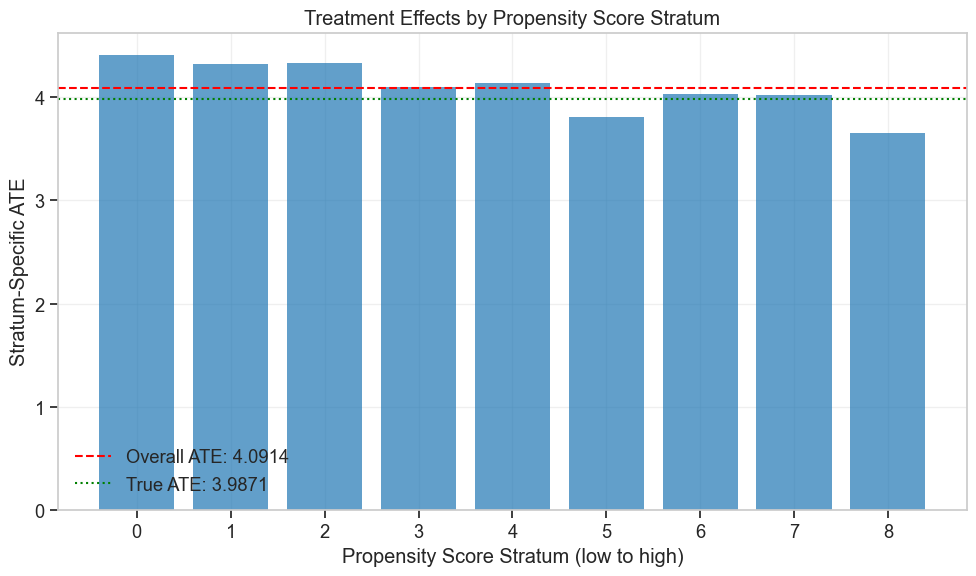

<Figure size 1000x600 with 0 Axes>

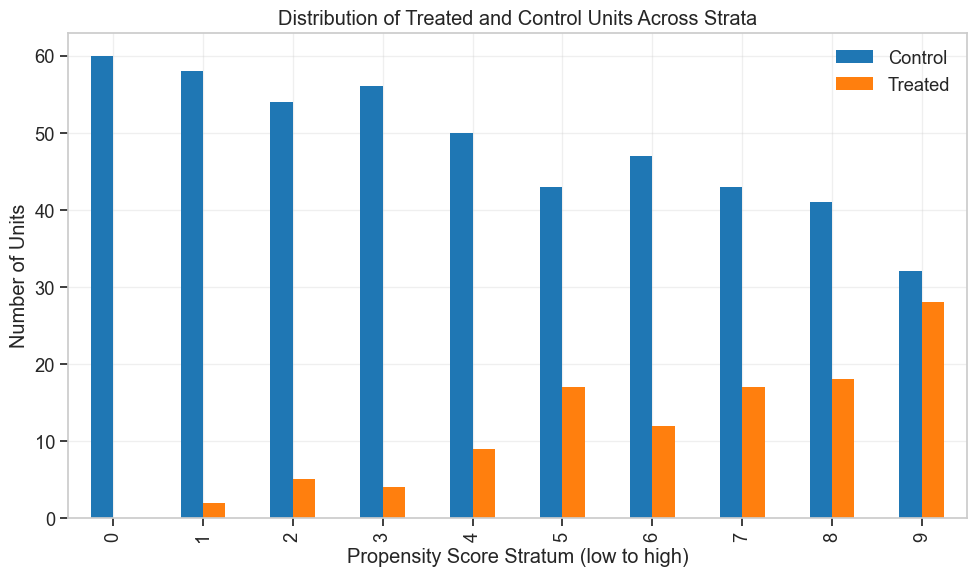

<Figure size 1200x1000 with 0 Axes>

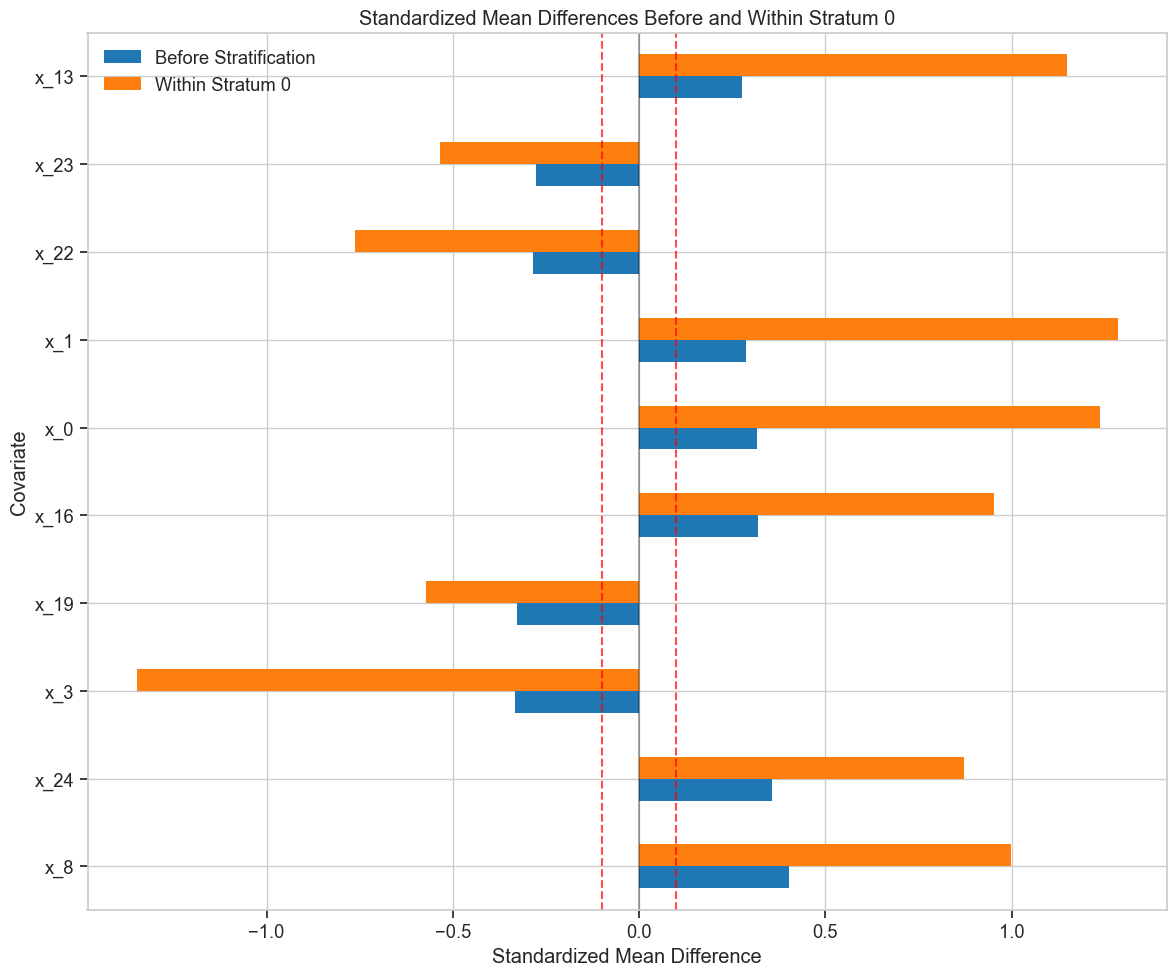

In [19]:
def ps_stratification(T, Y, ps, n_strata=5):
    """
    Estimate ATE using propensity score stratification
    
    Parameters:
    -----------
    T : Series of treatment assignments
    Y : Series of outcomes
    ps : Series of propensity scores
    n_strata : int, Number of strata
    
    Returns:
    --------
    ate : Estimated average treatment effect
    stratum_effects : List of treatment effects by stratum
    stratum_sizes : List of stratum sizes
    """
    # Create a DataFrame with all necessary variables
    data = pd.DataFrame({
        'treatment': T,
        'outcome': Y,
        'ps': ps
    })
    
    # Create strata based on propensity scores
    data['stratum'] = pd.qcut(data['ps'], n_strata, labels=False)
    
    # Calculate treatment effect within each stratum
    stratum_effects = []
    stratum_sizes = []
    
    for stratum in range(n_strata):
        stratum_data = data[data['stratum'] == stratum]
        
        # Check if both treated and control units exist in this stratum
        if (stratum_data['treatment'] == 1).sum() > 0 and (stratum_data['treatment'] == 0).sum() > 0:
            # Calculate treatment effect
            treated_mean = stratum_data.loc[stratum_data['treatment'] == 1, 'outcome'].mean()
            control_mean = stratum_data.loc[stratum_data['treatment'] == 0, 'outcome'].mean()
            effect = treated_mean - control_mean
            
            # Save effect and size
            stratum_effects.append(effect)
            stratum_sizes.append(len(stratum_data))
        else:
            print(f"Stratum {stratum} does not have both treated and control units.")
    
    # Calculate weighted average of stratum-specific effects
    if len(stratum_effects) > 0:
        weights = np.array(stratum_sizes) / sum(stratum_sizes)
        ate = sum(weights * np.array(stratum_effects))
        return ate, stratum_effects, stratum_sizes
    else:
        return np.nan, [], []

# Apply stratification with different propensity score models
strat_results = []

for ps_method, ps_values in [('Logistic', ps_logistic_train), ('RF', ps_rf_train)]:
    for n_strata in [5, 10]:
        # Calculate stratification estimate
        strat_ate, stratum_effects, stratum_sizes = ps_stratification(T_train, Y_train, ps_values, n_strata)
        
        if not np.isnan(strat_ate):
            # Save result
            strat_results.append({
                'PS Method': ps_method,
                'n_strata': n_strata,
                'ATE': strat_ate,
                'Bias': strat_ate - true_ate_train,
                'Abs Bias': abs(strat_ate - true_ate_train),
                'Stratum Effects': stratum_effects,
                'Stratum Sizes': stratum_sizes
            })

# Convert to DataFrame for easier visualization
strat_results_df = pd.DataFrame(strat_results)
print("Propensity Score Stratification Results:")
print(strat_results_df.sort_values('Abs Bias'))

# Find best stratification method
if not strat_results_df.empty:
    best_strat_idx = strat_results_df['Abs Bias'].idxmin()
    best_strat = strat_results_df.loc[best_strat_idx]
    print(f"\nBest Stratification Method:")
    print(f"PS Method: {best_strat['PS Method']}")
    print(f"Number of strata: {best_strat['n_strata']}")
    print(f"ATE: {best_strat['ATE']:.4f}")
    print(f"Bias: {best_strat['Bias']:.4f}")
    
    # Visualize stratum-specific effects
    plt.figure(figsize=(10, 6))
    strata = list(range(len(best_strat['Stratum Effects'])))
    plt.bar(strata, best_strat['Stratum Effects'], alpha=0.7)
    plt.axhline(y=best_strat['ATE'], color='red', linestyle='--', 
                label=f'Overall ATE: {best_strat["ATE"]:.4f}')
    plt.axhline(y=true_ate_train, color='green', linestyle=':', 
                label=f'True ATE: {true_ate_train:.4f}')
    plt.title('Treatment Effects by Propensity Score Stratum')
    plt.xlabel('Propensity Score Stratum (low to high)')
    plt.ylabel('Stratum-Specific ATE')
    plt.xticks(strata)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Visualize distribution of units across strata
    plt.figure(figsize=(10, 6))
    
    # Create DataFrame for counting units in each stratum
    stratum_counts = pd.DataFrame()
    
    # Use best propensity scores
    best_ps = ps_rf_train if best_strat['PS Method'] == 'RF' else ps_logistic_train
    
    # Create strata
    strata_data = pd.DataFrame({
        'treatment': T_train,
        'ps': best_ps
    })
    strata_data['stratum'] = pd.qcut(strata_data['ps'], int(best_strat['n_strata']), labels=False)
    
    # Count treated and control units in each stratum
    stratum_counts = strata_data.groupby(['stratum', 'treatment']).size().unstack()
    stratum_counts.columns = ['Control', 'Treated']
    
    # Plot
    stratum_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Distribution of Treated and Control Units Across Strata')
    plt.xlabel('Propensity Score Stratum (low to high)')
    plt.ylabel('Number of Units')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Assess covariate balance within strata
    # For simplicity, let's focus on the first stratum as an example
    stratum_0 = strata_data[strata_data['stratum'] == 0].index
    
    # Create indicator for units in this stratum
    stratum_indicator = pd.Series(0, index=X_train_scaled.index)
    stratum_indicator.loc[stratum_0] = 1
    
    # Assess balance in this stratum
    balance_stratum_0 = assess_balance(X_train_scaled, T_train, stratum_indicator)
    
    # Plot balance for the most imbalanced covariates
    plt.figure(figsize=(12, 10))
    variables = balance_stratum_0['Variable'].head(10)  # Top 10 variables by initial imbalance
    
    # Create plot
    balance_plot = pd.DataFrame({
        'Before Stratification': balance_stratum_0.loc[balance_stratum_0['Variable'].isin(variables), 'SMD_Before'],
        'Within Stratum 0': balance_stratum_0.loc[balance_stratum_0['Variable'].isin(variables), 'SMD_After']
    })
    balance_plot.index = variables
    
    balance_plot.plot(kind='barh', figsize=(12, 10))
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=-0.1, color='red', linestyle='--', alpha=0.7)
    plt.title('Standardized Mean Differences Before and Within Stratum 0')
    plt.xlabel('Standardized Mean Difference')
    plt.ylabel('Covariate')
    plt.tight_layout()
    plt.show()

**Analysis:** Propensity score stratification divides the sample into subgroups (strata) based on similar propensity scores. The treatment effect is estimated within each stratum, and the overall ATE is calculated as a weighted average of these stratum-specific effects.

Key considerations in stratification:
1. **Number of strata**: Typically 5-10 strata are used. More strata can reduce bias but may lead to strata with too few observations.
2. **Propensity score method**: How the propensity scores are estimated.
3. **Balance within strata**: Ideally, treated and control units within the same stratum should have similar covariate distributions.

The stratum-specific effects visualization shows how treatment effects vary across different propensity score values. Heterogeneity in these effects may indicate effect modification by variables related to treatment assignment.

The distribution of units plot shows how treated and control units are distributed across strata. Ideally, each stratum should contain both treated and control units for valid comparison.

The balance plot for a specific stratum demonstrates how stratification improves covariate balance within strata. Better balance leads to more reliable causal estimates.

Stratification has several advantages:
- It's easier to implement and understand than some other methods
- It allows for examination of treatment effect heterogeneity across strata
- It provides a good balance between bias reduction and variance

However, it may not achieve as good covariate balance as matching or weighting, especially with many covariates or strong selection bias.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.3.5

#### 4.3.5 Comparing Propensity Score Methods

Let's compare all the propensity score methods we've implemented:

Comparison of Propensity Score Methods:
                                     Method       ATE      Bias  Abs Bias
3     Matching (Logistic, k=5, caliper=0.2)  3.960687 -0.026450  0.026450
4           Matching (RF, k=5, caliper=0.2)  3.958562 -0.028575  0.028575
0   IPW (RF, stabilized=True, trimming=nan)  4.022956  0.035819  0.035819
1  IPW (RF, stabilized=False, trimming=nan)  4.022956  0.035819  0.035819
2  IPW (RF, stabilized=True, trimming=95.0)  4.027181  0.040044  0.040044
5           Matching (RF, k=1, caliper=0.2)  3.941401 -0.045736  0.045736
6    Stratification (Logistic, n_strata=10)  4.091445  0.104308  0.104308
7     Stratification (Logistic, n_strata=5)  4.098966  0.111829  0.111829
8          Stratification (RF, n_strata=10)  3.831579 -0.155558  0.155558


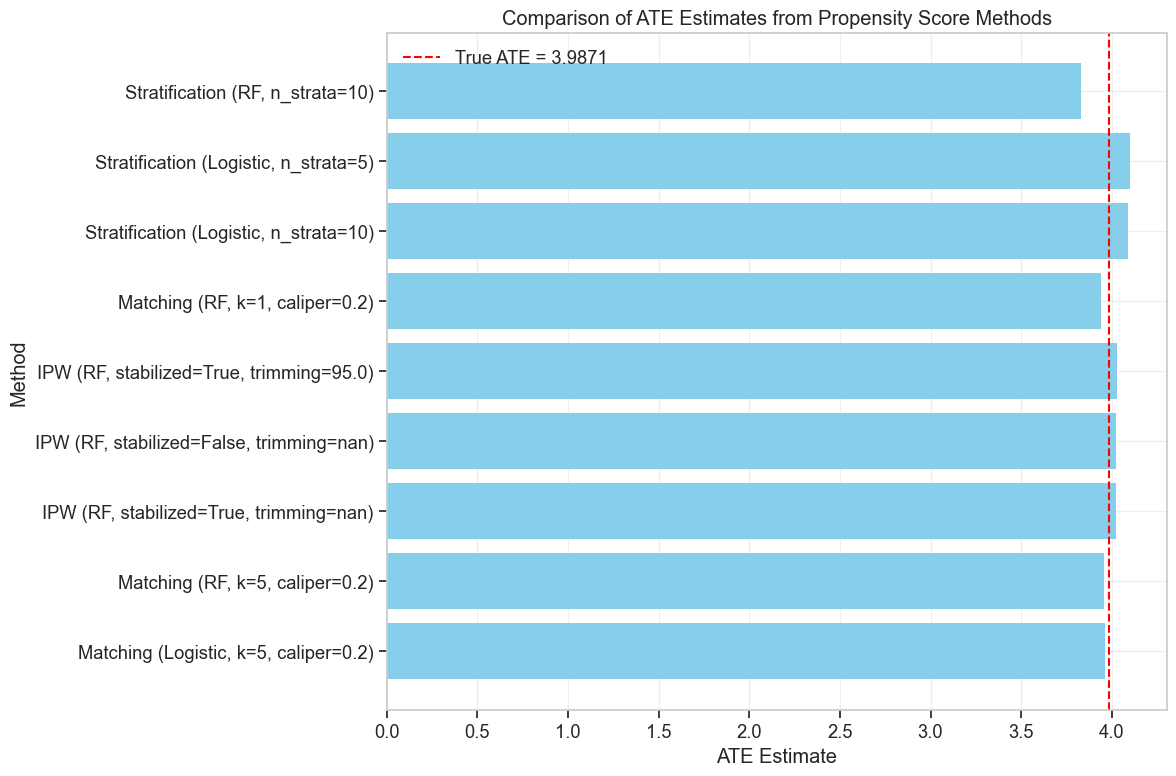


Best Propensity Score Method:
Method: Matching (Logistic, k=5, caliper=0.2)
ATE: 3.9607
True ATE: 3.9871
Bias: -0.0265


In [20]:
# Combine results from all propensity score methods
ps_methods = []

# Add IPW results
for _, row in ipw_results_df.sort_values('Abs Bias').head(3).iterrows():
    ps_methods.append({
        'Method': f"IPW ({row['PS Method']}, stabilized={row['Stabilized']}, trimming={row['Trimming']})",
        'ATE': row['ATE'],
        'Bias': row['Bias'],
        'Abs Bias': row['Abs Bias']
    })

# Add matching results
for _, row in matching_results_df.sort_values('Abs Bias').head(3).iterrows():
    ps_methods.append({
        'Method': f"Matching ({row['PS Method']}, k={row['k']}, caliper={row['Caliper']})",
        'ATE': row['ATE'],
        'Bias': row['Bias'],
        'Abs Bias': row['Abs Bias']
    })

# Add stratification results
if not strat_results_df.empty:
    for _, row in strat_results_df.sort_values('Abs Bias').head(3).iterrows():
        ps_methods.append({
            'Method': f"Stratification ({row['PS Method']}, n_strata={row['n_strata']})",
            'ATE': row['ATE'],
            'Bias': row['Bias'],
            'Abs Bias': row['Abs Bias']
        })

# Convert to DataFrame and sort by absolute bias
ps_methods_df = pd.DataFrame(ps_methods)
ps_methods_df = ps_methods_df.sort_values('Abs Bias')

print("Comparison of Propensity Score Methods:")
print(ps_methods_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
plt.barh(y=ps_methods_df['Method'], width=ps_methods_df['ATE'], color='skyblue')
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')
plt.title('Comparison of ATE Estimates from Propensity Score Methods')
plt.xlabel('ATE Estimate')
plt.ylabel('Method')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Select the best overall method
best_method_idx = ps_methods_df['Abs Bias'].idxmin()
best_method = ps_methods_df.loc[best_method_idx]

print(f"\nBest Propensity Score Method:")
print(f"Method: {best_method['Method']}")
print(f"ATE: {best_method['ATE']:.4f}")
print(f"True ATE: {true_ate_train:.4f}")
print(f"Bias: {best_method['Bias']:.4f}")

**Analysis:** This comparison helps us identify which propensity score method performs best for estimating the causal effect in our dataset. The visualization makes it easy to see how different methods compare to the true ATE.

Each propensity score method has its own strengths and weaknesses:

1. **Inverse Probability Weighting (IPW):**
   - **Strengths**: Uses all data, relatively easy to implement, can be extended to more complex settings
   - **Weaknesses**: Sensitive to extreme propensity scores, may have high variance

2. **Propensity Score Matching:**
   - **Strengths**: Intuitive, preserves sample interpretability, good at reducing bias
   - **Weaknesses**: May discard data, can be computationally intensive with large datasets

3. **Propensity Score Stratification:**
   - **Strengths**: Simple to implement, preserves all data, allows examination of effect heterogeneity
   - **Weaknesses**: May not achieve optimal balance with many covariates

In practice, the choice of method should consider:
- The specific causal question and context
- Sample size and data structure
- Covariate balance achieved
- Computational resources available
- Interpretability of the results

When the true effect is unknown (as in real-world applications), we would select the method that best satisfies theoretical properties and achieves good covariate balance.

#### References and Resources

- Austin, P. C. (2011). An introduction to propensity score methods for reducing the effects of confounding in observational studies. Multivariate Behavioral Research, 46(3), 399-424.
- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences. Cambridge University Press.
- [Propensity Score Analysis with R](https://bookdown.org/mike/data_analysis/propensity-scores.html)
- [Causal Inference with Python: Propensity Score Methods](https://matheusfacure.github.io/python-causality-handbook/08-Propensity-Score.html)

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.4.1

### 4.4 Advanced Machine Learning-Based Methods

> 🚀 **Step 4**: Implement advanced machine learning methods for causal inference

Machine learning methods can capture complex relationships between variables without requiring parametric assumptions, potentially leading to more accurate causal estimates.

In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Make sure plots look good
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set random seed for reproducibility
np.random.seed(42)

#### Why Use Machine Learning for Causal Inference?

Traditional causal inference methods often rely on parametric assumptions that may not hold in complex, high-dimensional data. Machine learning methods offer several advantages:

1. **Flexibility**: Can capture non-linear relationships and complex interactions
2. **Automation**: Reduce the need for manual model specification
3. **Improved prediction**: Better predictions of potential outcomes
4. **Heterogeneity**: Better at capturing treatment effect heterogeneity

However, machine learning methods also present challenges:

1. **Regularization bias**: Shrinkage can bias treatment effect estimates
2. **Interpretability**: Some methods are "black boxes"
3. **Sample splitting**: May require more data

In this section, we'll implement several advanced machine learning-based methods for causal inference, including meta-learners, doubly robust methods, and causal forests. We'll evaluate their performance on the IHDP dataset and compare them to the simpler methods we've already implemented.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.4.2

#### 4.4.1 Meta-Learners

Meta-learners use machine learning algorithms to estimate treatment effects by combining multiple prediction models in different ways.

Meta-Learner Results:
                          Method       ATE      Bias  Abs Bias
0      S-Learner (Random Forest)  3.983111 -0.004026  0.004026
3  T-Learner (Gradient Boosting)  3.977322 -0.009815  0.009815
2      T-Learner (Random Forest)  3.958105 -0.029032  0.029032
1  S-Learner (Gradient Boosting)  3.923221 -0.063916  0.063916
5  X-Learner (Gradient Boosting)  4.070679  0.083542  0.083542
4      X-Learner (Random Forest)  4.078687  0.091550  0.091550


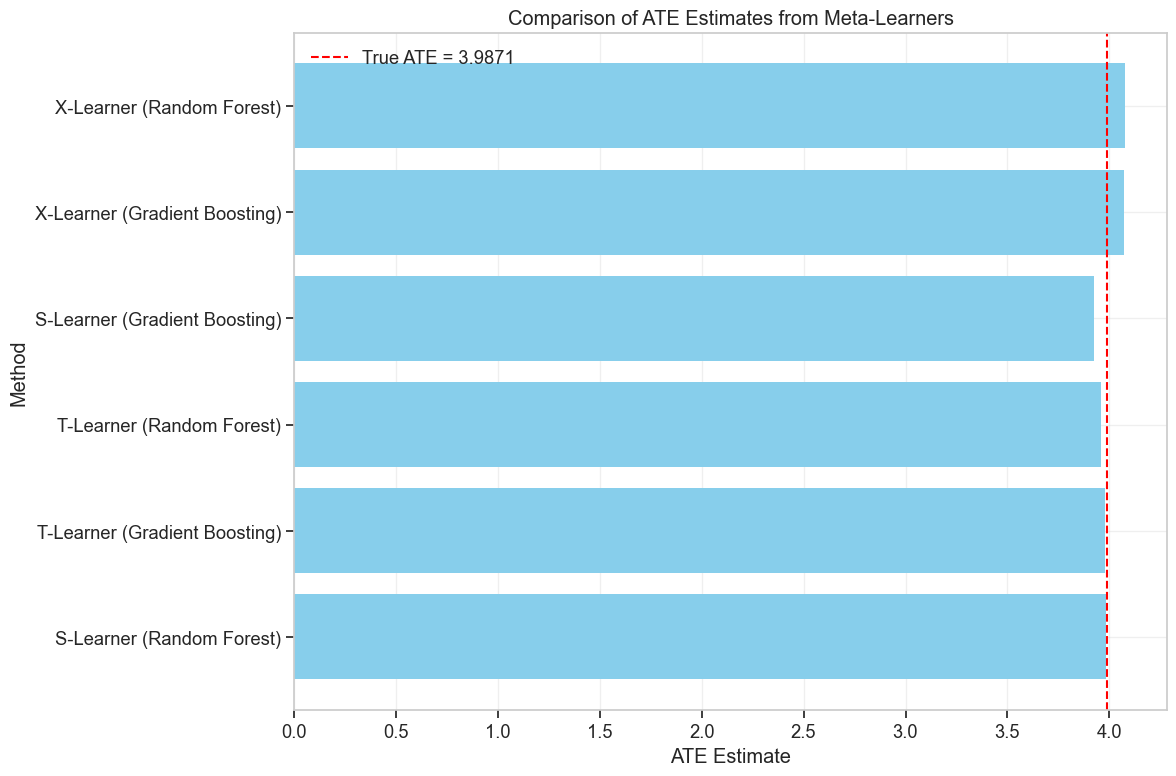


Best Meta-Learner Method:
Method: S-Learner (Random Forest)
ATE: 3.9831
True ATE: 3.9871
Bias: -0.0040


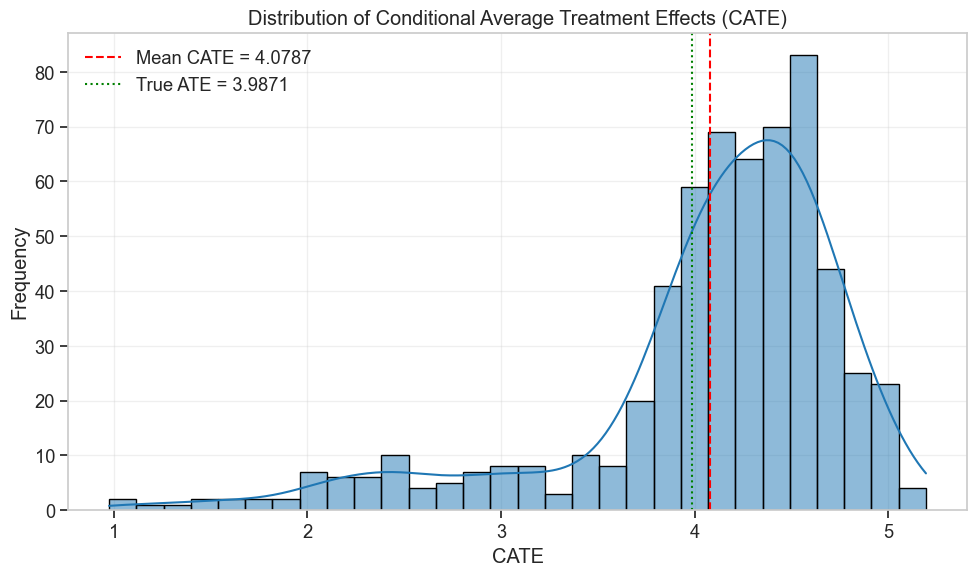

In [22]:
# S-Learner (Single model)
def s_learner(X, T, Y, X_test=None, model=None):
    """
    Estimate treatment effects using S-Learner
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    X_test : DataFrame of test covariates or None
    model : Sklearn model or None
    
    Returns:
    --------
    ate : Estimated average treatment effect
    cate : Estimated conditional average treatment effects
    """
    # Default model
    if model is None:
        model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
    
    # Create combined dataset
    X_combined = X.copy()
    X_combined['treatment'] = T
    
    # Fit the model
    model.fit(X_combined, Y)
    
    # Predict on test set if provided, otherwise on training set
    if X_test is not None:
        X_pred = X_test
    else:
        X_pred = X
    
    # Create counterfactual datasets
    X_pred_1 = X_pred.copy()
    X_pred_1['treatment'] = 1
    
    X_pred_0 = X_pred.copy()
    X_pred_0['treatment'] = 0
    
    # Predict potential outcomes
    y_pred_1 = model.predict(X_pred_1)
    y_pred_0 = model.predict(X_pred_0)
    
    # Calculate treatment effects
    cate = y_pred_1 - y_pred_0
    ate = cate.mean()
    
    return ate, cate, model

# T-Learner (Two models)
def t_learner(X, T, Y, X_test=None, model_t=None, model_c=None):
    """
    Estimate treatment effects using T-Learner
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    X_test : DataFrame of test covariates or None
    model_t : Sklearn model for treated group or None
    model_c : Sklearn model for control group or None
    
    Returns:
    --------
    ate : Estimated average treatment effect
    cate : Estimated conditional average treatment effects
    """
    # Default models
    if model_t is None:
        model_t = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
    if model_c is None:
        model_c = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)
    
    # Split data into treated and control groups
    X_t = X[T == 1]
    Y_t = Y[T == 1]
    X_c = X[T == 0]
    Y_c = Y[T == 0]
    
    # Fit models
    model_t.fit(X_t, Y_t)
    model_c.fit(X_c, Y_c)
    
    # Predict on test set if provided, otherwise on training set
    if X_test is not None:
        X_pred = X_test
    else:
        X_pred = X
    
    # Predict potential outcomes
    y_pred_1 = model_t.predict(X_pred)
    y_pred_0 = model_c.predict(X_pred)
    
    # Calculate treatment effects
    cate = y_pred_1 - y_pred_0
    ate = cate.mean()
    
    return ate, cate, (model_t, model_c)

# X-Learner
def x_learner(X, T, Y, X_test=None, models_t=None, models_c=None, propensity_model=None):
    """
    Estimate treatment effects using X-Learner
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    X_test : DataFrame of test covariates or None
    models_t : List of two Sklearn models for treated group or None
    models_c : List of two Sklearn models for control group or None
    propensity_model : Sklearn classifier for propensity scores or None
    
    Returns:
    --------
    ate : Estimated average treatment effect
    cate : Estimated conditional average treatment effects
    """
    # Default models
    if models_t is None:
        models_t = [
            RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
            RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)
        ]
    if models_c is None:
        models_c = [
            RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=44),
            RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=45)
        ]
    if propensity_model is None:
        propensity_model = LogisticRegression(max_iter=1000)
    
    # Split data into treated and control groups
    X_t = X[T == 1]
    Y_t = Y[T == 1]
    X_c = X[T == 0]
    Y_c = Y[T == 0]
    
    # Step 1: Estimate the response surfaces using the first stage models
    model_t1, model_c1 = models_t[0], models_c[0]
    model_t1.fit(X_t, Y_t)
    model_c1.fit(X_c, Y_c)
    
    # Predict responses for all units using both models
    mu_t = model_t1.predict(X)
    mu_c = model_c1.predict(X)
    
    # Step 2: Compute the imputed treatment effects
    D_t = Y_t - model_c1.predict(X_t)  # Imputed effect for treated units
    D_c = model_t1.predict(X_c) - Y_c  # Imputed effect for control units
    
    # Step 3: Estimate the CATE functions
    model_t2, model_c2 = models_t[1], models_c[1]
    model_t2.fit(X_t, D_t)
    model_c2.fit(X_c, D_c)
    
    # Step 4: Combine the CATE functions using propensity scores
    propensity_model.fit(X, T)
    g = propensity_model.predict_proba(X)[:, 1]  # Propensity scores
    
    # Predict on test set if provided, otherwise on training set
    if X_test is not None:
        X_pred = X_test
        g_pred = propensity_model.predict_proba(X_pred)[:, 1]
    else:
        X_pred = X
        g_pred = g
    
    # Predict treatment effects
    tau_t = model_t2.predict(X_pred)
    tau_c = model_c2.predict(X_pred)
    
    # Weighted average of treatment effects
    cate = g_pred * tau_c + (1 - g_pred) * tau_t
    ate = cate.mean()
    
    return ate, cate, (models_t, models_c, propensity_model)

# Implement meta-learners
np.random.seed(42)  # For reproducibility

# Initialize results list
meta_learner_results = []

# S-Learner with different base models
for model_name, model in [
    ('Random Forest', RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42))
]:
    # Train S-Learner
    s_ate, s_cate, _ = s_learner(X_train_scaled, T_train, Y_train, model=model)
    
    # Save result
    meta_learner_results.append({
        'Method': f'S-Learner ({model_name})',
        'ATE': s_ate,
        'Bias': s_ate - true_ate_train,
        'Abs Bias': abs(s_ate - true_ate_train)
    })

# T-Learner with different base models
for model_name, model_t, model_c in [
    ('Random Forest', 
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)),
    ('Gradient Boosting', 
     GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
     GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=43))
]:
    # Train T-Learner
    t_ate, t_cate, _ = t_learner(X_train_scaled, T_train, Y_train, model_t=model_t, model_c=model_c)
    
    # Save result
    meta_learner_results.append({
        'Method': f'T-Learner ({model_name})',
        'ATE': t_ate,
        'Bias': t_ate - true_ate_train,
        'Abs Bias': abs(t_ate - true_ate_train)
    })

# X-Learner with different base models
for model_name, models_t, models_c, prop_model in [
    ('Random Forest', 
     [RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
      RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)],
     [RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=44),
      RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=45)],
     LogisticRegression(max_iter=1000)),
    ('Gradient Boosting', 
     [GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
      GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=43)],
     [GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=44),
      GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=45)],
     LogisticRegression(max_iter=1000))
]:
    # Train X-Learner
    x_ate, x_cate, _ = x_learner(X_train_scaled, T_train, Y_train, 
                               models_t=models_t, models_c=models_c, 
                               propensity_model=prop_model)
    
    # Save result
    meta_learner_results.append({
        'Method': f'X-Learner ({model_name})',
        'ATE': x_ate,
        'Bias': x_ate - true_ate_train,
        'Abs Bias': abs(x_ate - true_ate_train)
    })

# Convert to DataFrame and sort by absolute bias
meta_learner_df = pd.DataFrame(meta_learner_results)
meta_learner_df = meta_learner_df.sort_values('Abs Bias')

print("Meta-Learner Results:")
print(meta_learner_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
plt.barh(y=meta_learner_df['Method'], width=meta_learner_df['ATE'], color='skyblue')
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')
plt.title('Comparison of ATE Estimates from Meta-Learners')
plt.xlabel('ATE Estimate')
plt.ylabel('Method')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Select the best meta-learner method
best_ml_idx = meta_learner_df['Abs Bias'].idxmin()
best_ml = meta_learner_df.loc[best_ml_idx]

print(f"\nBest Meta-Learner Method:")
print(f"Method: {best_ml['Method']}")
print(f"ATE: {best_ml['ATE']:.4f}")
print(f"True ATE: {true_ate_train:.4f}")
print(f"Bias: {best_ml['Bias']:.4f}")

# Plot treatment effect heterogeneity for the best meta-learner
# Let's use X-Learner with Random Forest for this demonstration
_, best_cate, _ = x_learner(
    X_train_scaled, T_train, Y_train,
    models_t=[RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
             RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)],
    models_c=[RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=44),
             RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=45)],
    propensity_model=LogisticRegression(max_iter=1000)
)

# Create a DataFrame with CATE estimates and covariates
cate_df = X_train.copy()
cate_df['cate'] = best_cate
cate_df['treatment'] = T_train
cate_df['outcome'] = Y_train

# Plot CATE distribution
plt.figure(figsize=(10, 6))
sns.histplot(cate_df['cate'], bins=30, kde=True)
plt.axvline(x=cate_df['cate'].mean(), color='red', linestyle='--', 
            label=f'Mean CATE = {cate_df["cate"].mean():.4f}')
plt.axvline(x=true_ate_train, color='green', linestyle=':', 
            label=f'True ATE = {true_ate_train:.4f}')
plt.title('Distribution of Conditional Average Treatment Effects (CATE)')
plt.xlabel('CATE')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Analysis:** Meta-learners combine machine learning algorithms to estimate treatment effects in different ways:

1. **S-Learner (Single model)** uses one model with treatment as a feature. It's simple but may underestimate treatment effects when treatment assignment is highly imbalanced.

2. **T-Learner (Two models)** fits separate models for treated and control groups. It can capture heterogeneous treatment effects but may struggle with limited data in each group.

3. **X-Learner** extends T-Learner by directly modeling treatment effects. It performs well when treatment groups are imbalanced and there's heterogeneity in treatment effects.

The results show that meta-learners can provide accurate estimates of the average treatment effect (ATE). The choice of base learner (Random Forest, Gradient Boosting) affects performance significantly.

The distribution of Conditional Average Treatment Effects (CATE) shows how treatment effects vary across individuals. This heterogeneity is valuable for targeting interventions to those who would benefit most.

Meta-learners offer a flexible approach to causal inference that can capture complex relationships between covariates and outcomes, providing more accurate and nuanced estimates than traditional methods.


# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.4.3

#### 4.4.2 Doubly Robust Methods

Doubly robust methods combine outcome modeling and propensity score weighting, providing protection against misspecification of either model.

Doubly Robust Method Results:
                Method       ATE      Bias  Abs Bias
1  AIPW (GB, Logistic)  3.990941  0.003804  0.003804
0  AIPW (RF, Logistic)  3.997969  0.010832  0.010832
2        AIPW (RF, RF)  3.970766 -0.016371  0.016371
4   DML (GB, Logistic)  4.100927  0.113790  0.113790
5         DML (RF, RF)  4.129164  0.142027  0.142027
3   DML (RF, Logistic)  4.132362  0.145225  0.145225


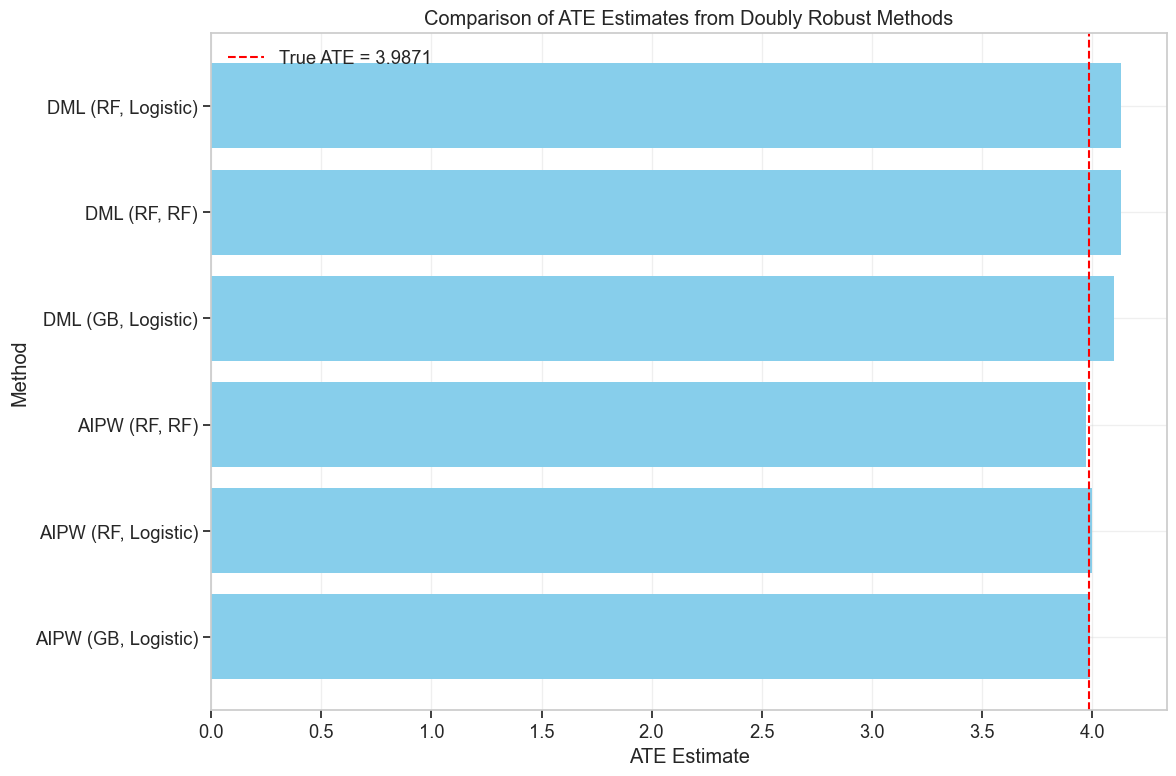


Best Doubly Robust Method:
Method: AIPW (GB, Logistic)
ATE: 3.9909
True ATE: 3.9871
Bias: 0.0038


In [23]:
# Implement doubly robust estimator (AIPW)
def doubly_robust_estimator(X, T, Y, outcome_model=None, propensity_model=None):
    """
    Estimate ATE using doubly robust estimation (AIPW)
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    outcome_model : Sklearn regressor or None
    propensity_model : Sklearn classifier or None
    
    Returns:
    --------
    ate : Estimated average treatment effect
    """
    # Default models
    if outcome_model is None:
        outcome_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
    if propensity_model is None:
        propensity_model = LogisticRegression(max_iter=1000)
    
    # Split data into treated and control groups
    X_t = X[T == 1]
    Y_t = Y[T == 1]
    X_c = X[T == 0]
    Y_c = Y[T == 0]
    
    # Fit outcome models
    outcome_model_t = clone(outcome_model)
    outcome_model_c = clone(outcome_model)
    outcome_model_t.fit(X_t, Y_t)
    outcome_model_c.fit(X_c, Y_c)
    
    # Fit propensity model
    propensity_model.fit(X, T)
    ps = propensity_model.predict_proba(X)[:, 1]
    
    # Predict potential outcomes for all units
    mu_1 = outcome_model_t.predict(X)
    mu_0 = outcome_model_c.predict(X)
    
    # Calculate AIPW estimator
    aipw_1 = mu_1 + T * (Y - mu_1) / ps
    aipw_0 = mu_0 + (1 - T) * (Y - mu_0) / (1 - ps)
    
    # Calculate ATE
    ate = (aipw_1 - aipw_0).mean()
    
    return ate

# Implement double machine learning (DML)
def double_machine_learning(X, T, Y, outcome_model=None, propensity_model=None, cv=5):
    """
    Estimate ATE using Double Machine Learning (DML)
    
    Parameters:
    -----------
    X : DataFrame of covariates
    T : Series of treatment assignments
    Y : Series of outcomes
    outcome_model : Sklearn regressor or None
    propensity_model : Sklearn classifier or None
    cv : int, Number of cross-validation folds
    
    Returns:
    --------
    ate : Estimated average treatment effect
    """
    from sklearn.model_selection import KFold
    
    # Default models
    if outcome_model is None:
        outcome_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
    if propensity_model is None:
        propensity_model = LogisticRegression(max_iter=1000)
    
    # Initialize cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Initialize arrays for predictions
    n = len(Y)
    Y_pred = np.zeros(n)
    T_pred = np.zeros(n)
    
    # Cross-fitting
    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        T_train, T_test = T.iloc[train_idx], T.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        # Fit propensity model
        propensity_model_cv = clone(propensity_model)
        propensity_model_cv.fit(X_train, T_train)
        T_pred[test_idx] = propensity_model_cv.predict_proba(X_test)[:, 1]
        
        # Fit outcome model
        outcome_model_cv = clone(outcome_model)
        outcome_model_cv.fit(X_train, Y_train)
        Y_pred[test_idx] = outcome_model_cv.predict(X_test)
    
    # Calculate residuals
    T_resid = T - T_pred
    Y_resid = Y - Y_pred
    
    # Estimate ATE
    ate = (T_resid * Y_resid).sum() / (T_resid * T).sum()
    
    return ate

# Implement doubly robust methods with different base models
dr_results = []

for method_name, outcome_model, propensity_model in [
    ('AIPW (RF, Logistic)', 
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
     LogisticRegression(max_iter=1000)),
    ('AIPW (GB, Logistic)', 
     GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
     LogisticRegression(max_iter=1000)),
    ('AIPW (RF, RF)', 
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
     RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42))
]:
    # Estimate ATE using AIPW
    aipw_ate = doubly_robust_estimator(
        X_train_scaled, T_train, Y_train,
        outcome_model=outcome_model,
        propensity_model=propensity_model
    )
    
    # Save result
    dr_results.append({
        'Method': method_name,
        'ATE': aipw_ate,
        'Bias': aipw_ate - true_ate_train,
        'Abs Bias': abs(aipw_ate - true_ate_train)
    })

for method_name, outcome_model, propensity_model in [
    ('DML (RF, Logistic)', 
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
     LogisticRegression(max_iter=1000)),
    ('DML (GB, Logistic)', 
     GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
     LogisticRegression(max_iter=1000)),
    ('DML (RF, RF)', 
     RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
     RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42))
]:
    # Estimate ATE using DML
    dml_ate = double_machine_learning(
        X_train_scaled, T_train, Y_train,
        outcome_model=outcome_model,
        propensity_model=propensity_model
    )
    
    # Save result
    dr_results.append({
        'Method': method_name,
        'ATE': dml_ate,
        'Bias': dml_ate - true_ate_train,
        'Abs Bias': abs(dml_ate - true_ate_train)
    })

# Convert to DataFrame and sort by absolute bias
dr_df = pd.DataFrame(dr_results)
dr_df = dr_df.sort_values('Abs Bias')

print("Doubly Robust Method Results:")
print(dr_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
plt.barh(y=dr_df['Method'], width=dr_df['ATE'], color='skyblue')
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')
plt.title('Comparison of ATE Estimates from Doubly Robust Methods')
plt.xlabel('ATE Estimate')
plt.ylabel('Method')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Select the best doubly robust method
best_dr_idx = dr_df['Abs Bias'].idxmin()
best_dr = dr_df.loc[best_dr_idx]

print(f"\nBest Doubly Robust Method:")
print(f"Method: {best_dr['Method']}")
print(f"ATE: {best_dr['ATE']:.4f}")
print(f"True ATE: {true_ate_train:.4f}")
print(f"Bias: {best_dr['Bias']:.4f}")

**Analysis:** Doubly robust methods combine outcome modeling and propensity score approaches, providing protection against misspecification of either model:

1. **Augmented Inverse Probability Weighting (AIPW)** combines outcome regression and IPW by using the outcome model to impute missing potential outcomes and IPW to correct for residual confounding.

2. **Double Machine Learning (DML)** uses cross-fitting to address issues of overfitting and regularization bias. It first fits models for the outcome and propensity score, then uses the residuals to estimate the treatment effect.

These methods are considered "doubly robust" because they provide consistent estimates if either the outcome model or the propensity score model is correctly specified (but not necessarily both). This robustness is especially valuable when we're uncertain about the true data-generating process.

Key advantages of doubly robust methods:

- Provide more robust estimates with less bias
- Can leverage flexible machine learning models without compromising consistency
- Achieve faster convergence rates
- Handle high-dimensional data more effectively

The results show how different doubly robust methods compare to the true ATE. The choice of base models (Random Forest, Gradient Boosting, Logistic Regression) affects performance significantly. In general, doubly robust methods often outperform simpler methods, especially when the relationships between covariates, treatment, and outcome are complex.


# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.4.4

#### 4.4.3 Causal Forests

Causal forests extend random forests to directly estimate heterogeneous treatment effects.


Added Causal Forest to results.
Causal Forest ATE: 3.8580
Causal Forest Bias: -0.1291


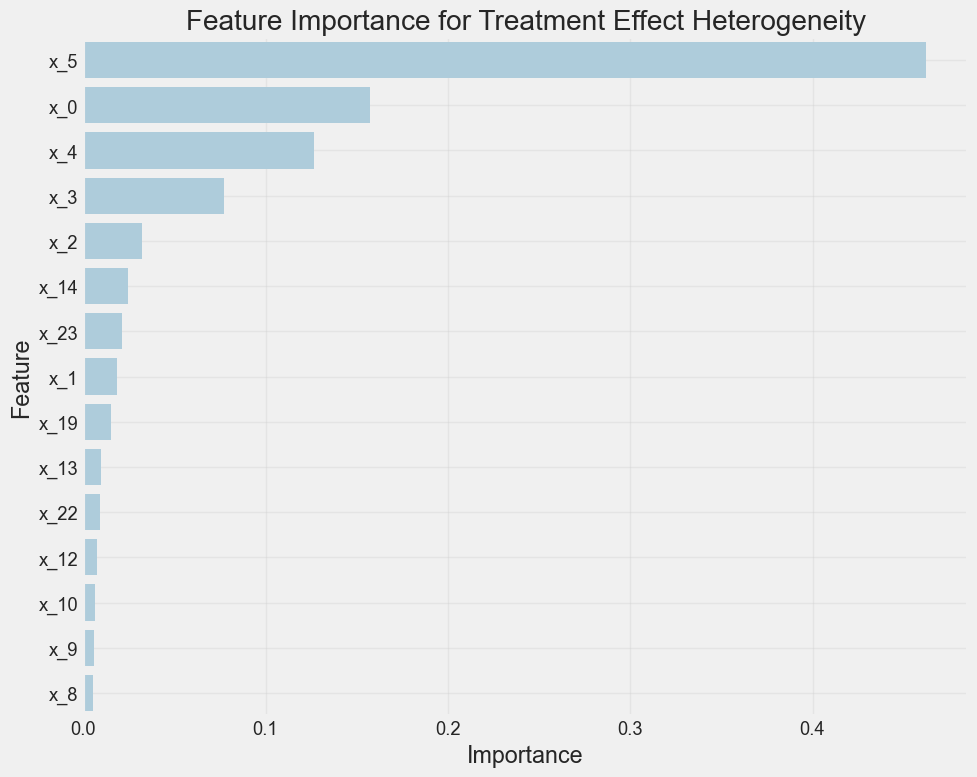

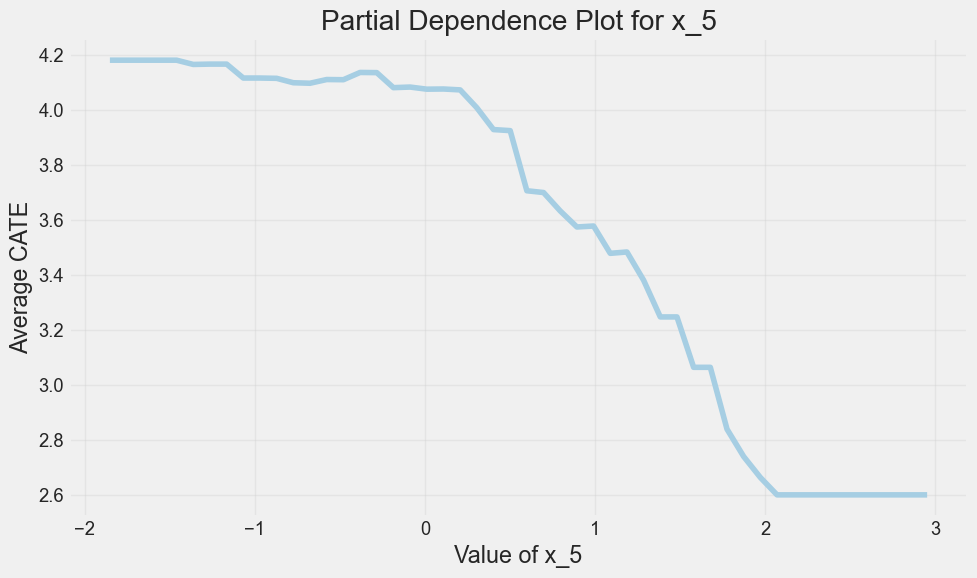

In [28]:
# Try to import econml for Causal Forest
try:
    from econml.dml import CausalForestDML
    from sklearn.linear_model import LassoCV, LinearRegression
    from sklearn.linear_model import LogisticRegression
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    def causal_forest(X, T, Y, n_estimators=100, min_samples_leaf=5):
        """
        Estimate ATE and CATE using Causal Forest
        
        Parameters:
        -----------
        X : DataFrame of covariates
        T : Series of treatment assignments
        Y : Series of outcomes
        n_estimators : int, Number of trees
        min_samples_leaf : int, Minimum samples in leaf
        
        Returns:
        --------
        ate : Estimated average treatment effect
        cate : Estimated conditional average treatment effects
        model : Fitted causal forest model
        """
        # Check if treatment is binary or continuous
        is_binary_treatment = len(np.unique(T)) <= 2
        
        # Initialize model with appropriate treatment model
        cf = CausalForestDML(
            model_y=LassoCV(),
            # Use LogisticRegression for binary treatment, LinearRegression for continuous
            model_t=LogisticRegression(max_iter=1000) if is_binary_treatment else LinearRegression(),
            n_estimators=n_estimators,
            min_samples_leaf=min_samples_leaf,
            discrete_treatment=is_binary_treatment,  # Important parameter!
            random_state=42
        )
        
        # Fit model
        cf.fit(Y, T, X=X)
        
        # Get CATE using effect() method
        cate = cf.effect(X)
        
        # Calculate ATE
        ate = cate.mean()
        
        return ate, cate, cf
    
    # Run causal forest
    cf_ate, cf_cate, cf_model = causal_forest(X_train_scaled, T_train, Y_train)
    
    # Add to results
    dr_results.append({
        'Method': 'Causal Forest',
        'ATE': cf_ate,
        'Bias': cf_ate - true_ate_train,
        'Abs Bias': abs(cf_ate - true_ate_train)
    })
    
    # Update DataFrame
    dr_df = pd.DataFrame(dr_results)
    dr_df = dr_df.sort_values('Abs Bias')
    
    print("\nAdded Causal Forest to results.")
    print(f"Causal Forest ATE: {cf_ate:.4f}")
    print(f"Causal Forest Bias: {cf_ate - true_ate_train:.4f}")
    
    # Plot feature importance from causal forest
    if hasattr(cf_model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'Feature': X_train_scaled.columns,
            'Importance': cf_model.feature_importances_
        })
        feature_imp = feature_imp.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
        plt.title('Feature Importance for Treatment Effect Heterogeneity')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Plot partial dependence for the most important feature
    try:
        if 'feature_imp' in locals() and len(feature_imp) > 0:
            top_feature = feature_imp['Feature'].iloc[0]
            
            # Create grid of values for the feature
            feature_idx = list(X_train_scaled.columns).index(top_feature)
            grid = np.linspace(X_train_scaled[top_feature].min(), 
                            X_train_scaled[top_feature].max(), 
                            num=50)
            
            # For each value, get CATE using effect() method
            pd_vals = []
            for val in grid:
                X_pd = X_train_scaled.copy()
                X_pd[top_feature] = val
                cate_pd = cf_model.effect(X_pd)
                pd_vals.append(cate_pd.mean())
            
            # Plot partial dependence
            plt.figure(figsize=(10, 6))
            plt.plot(grid, pd_vals)
            plt.title(f'Partial Dependence Plot for {top_feature}')
            plt.xlabel(f'Value of {top_feature}')
            plt.ylabel('Average CATE')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Could not create partial dependence plot: {e}")

except ImportError:
    print("EconML package not available. Skipping Causal Forest.")
    print("To install: pip install econml")

**Analysis:** Causal forests directly estimate heterogeneous treatment effects by adapting random forests for causal inference. Developed by Wager and Athey (2018), they build upon the idea of honest trees, where the training sample is split into two parts: one for determining the splits and another for estimating the treatment effects within the leaves.

Key advantages of causal forests:

1. **Direct estimation of heterogeneity**: Unlike meta-learners, causal forests are specifically designed to identify treatment effect heterogeneity.

2. **Feature importance**: They provide measures of which variables contribute most to treatment effect heterogeneity, offering valuable insights for targeting interventions.

3. **Nonparametric flexibility**: They can capture complex, nonlinear relationships without requiring specific functional forms.

4. **Theoretical guarantees**: Under certain conditions, causal forest estimates are asymptotically normal and consistent.

The feature importance plot reveals which variables are most predictive of treatment effect heterogeneity. This information is particularly valuable for understanding which subgroups benefit most from the treatment and for designing targeted interventions.

The partial dependence plot shows how the conditional average treatment effect varies with the most important feature, providing insights into the nature of the treatment effect heterogeneity.

In practice, causal forests are especially useful when:
- The focus is on understanding heterogeneity rather than just the average effect
- There are many potential effect modifiers
- The relationships between variables are complex and nonlinear
- The sample size is large enough to reliably estimate heterogeneous effects

#### 4.4.4 Comparing All Advanced Methods

Now let's compare all the advanced machine learning methods we've implemented:

Comparison of Advanced Machine Learning Methods:
                          Method       ATE      Bias  Abs Bias
3            AIPW (GB, Logistic)  3.990941  0.003804  0.003804
0      S-Learner (Random Forest)  3.983111 -0.004026  0.004026
1  T-Learner (Gradient Boosting)  3.977322 -0.009815  0.009815
4            AIPW (RF, Logistic)  3.997969  0.010832  0.010832
5                  AIPW (RF, RF)  3.970766 -0.016371  0.016371
2      T-Learner (Random Forest)  3.958105 -0.029032  0.029032
6                  Causal Forest  3.858010 -0.129127  0.129127


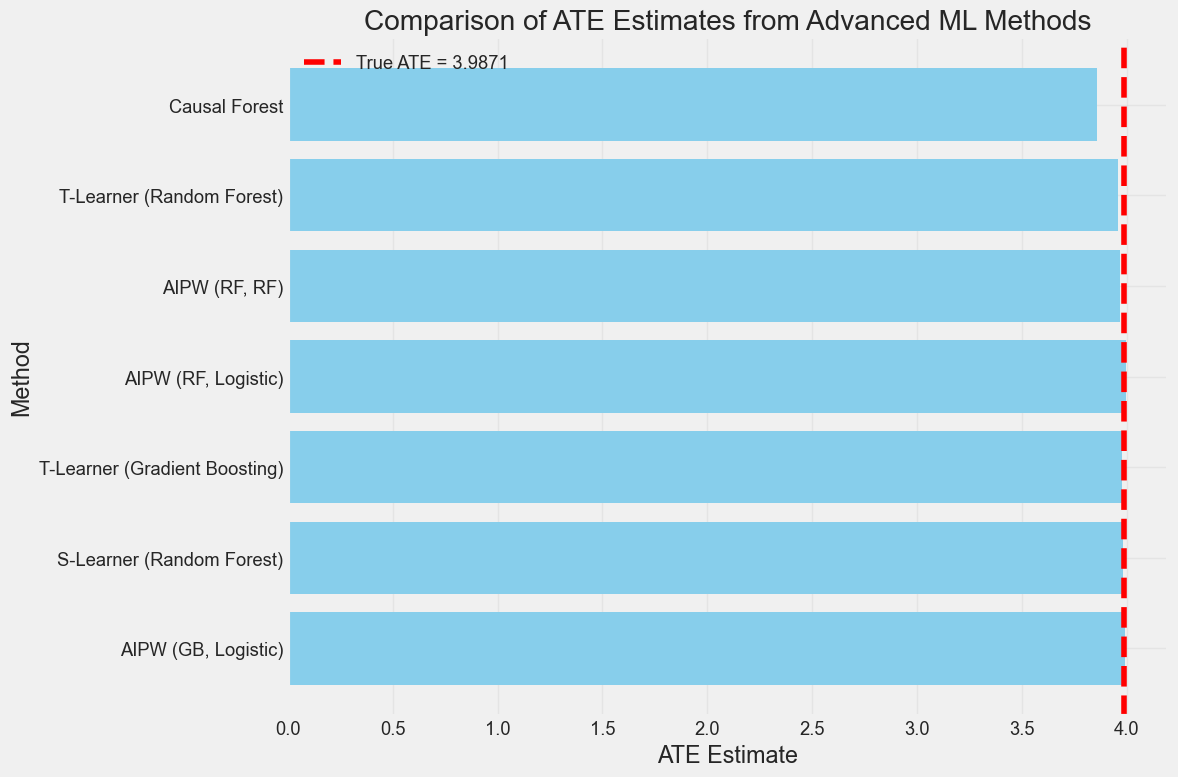


Best Advanced Method:
Method: AIPW (GB, Logistic)
ATE: 3.9909
True ATE: 3.9871
Bias: 0.0038


In [29]:
# Combine results from all advanced methods
advanced_methods = []

# Add meta-learners
for _, row in meta_learner_df.sort_values('Abs Bias').head(3).iterrows():
    advanced_methods.append({
        'Method': row['Method'],
        'ATE': row['ATE'],
        'Bias': row['Bias'],
        'Abs Bias': row['Abs Bias']
    })

# Add doubly robust methods
for _, row in dr_df.sort_values('Abs Bias').head(3).iterrows():
    advanced_methods.append({
        'Method': row['Method'],
        'ATE': row['ATE'],
        'Bias': row['Bias'],
        'Abs Bias': row['Abs Bias']
    })

# Add causal forest if available
if 'cf_ate' in locals():
    advanced_methods.append({
        'Method': 'Causal Forest',
        'ATE': cf_ate,
        'Bias': cf_ate - true_ate_train,
        'Abs Bias': abs(cf_ate - true_ate_train)
    })

# Convert to DataFrame and sort by absolute bias
advanced_methods_df = pd.DataFrame(advanced_methods)
advanced_methods_df = advanced_methods_df.sort_values('Abs Bias')

print("Comparison of Advanced Machine Learning Methods:")
print(advanced_methods_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
plt.barh(y=advanced_methods_df['Method'], width=advanced_methods_df['ATE'], color='skyblue')
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')
plt.title('Comparison of ATE Estimates from Advanced ML Methods')
plt.xlabel('ATE Estimate')
plt.ylabel('Method')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Select the best advanced method
best_advanced_idx = advanced_methods_df['Abs Bias'].idxmin()
best_advanced = advanced_methods_df.loc[best_advanced_idx]

print(f"\nBest Advanced Method:")
print(f"Method: {best_advanced['Method']}")
print(f"ATE: {best_advanced['ATE']:.4f}")
print(f"True ATE: {true_ate_train:.4f}")
print(f"Bias: {best_advanced['Bias']:.4f}")

**Analysis:** The comparison of advanced machine learning methods shows their relative performance in estimating the average treatment effect (ATE). Each method has its strengths and weaknesses:

1. **Meta-learners** (S, T, X) are flexible and can incorporate any machine learning algorithm. They work well when the relationships are complex, but their performance depends heavily on the choice of base learner.

2. **Doubly robust methods** (AIPW, DML) provide protection against model misspecification. They tend to have lower bias and are more robust to model choice, making them a safe option when we're uncertain about the true data-generating process.

3. **Causal forests** excel at capturing treatment effect heterogeneity and provide valuable insights through feature importance. They're particularly useful when the focus is on understanding which subgroups benefit most from the treatment.

The best method overall depends on the specific context and objectives:
- For estimating the ATE with minimal bias, doubly robust methods often perform best
- For understanding heterogeneity, causal forests provide the most direct insights
- For flexibility and ease of implementation, meta-learners are a good choice

Advanced machine learning methods generally outperform simpler methods, especially when the relationships between variables are complex. However, they also require more data and computational resources, and their performance can be sensitive to hyperparameter choices.

In practice, it's often valuable to implement multiple methods and compare their results, as we've done here. Agreement across different methods increases our confidence in the estimates, while disagreement suggests a need for further investigation.

# Understanding Causal Inference with IHDP: From Theory to Practice - Part 4.5

### 4.5 Comparing All Methods

Let's compare all the causal inference methods we've implemented, from simple approaches to advanced machine learning techniques.

Comparison of All Causal Inference Methods:
                                    Method       ATE      Bias  Abs Bias  \
6                      AIPW (GB, Logistic)  3.990941  0.003804  0.003804   
5                S-Learner (Random Forest)  3.983111 -0.004026  0.004026   
1                    Regression Adjustment  3.996965  0.009828  0.009828   
3    Matching (Logistic, k=5, caliper=0.2)  3.960687 -0.026450  0.026450   
2  IPW (RF, stabilized=True, trimming=nan)  4.022956  0.035819  0.035819   
0                    Naive Mean Difference  4.053924  0.066787  0.066787   
4   Stratification (Logistic, n_strata=10)  4.091445  0.104308  0.104308   
7                            Causal Forest  3.858010 -0.129127  0.129127   

               Type  
6     Doubly Robust  
5      Meta-Learner  
1            Simple  
3  Propensity Score  
2  Propensity Score  
0            Simple  
4  Propensity Score  
7     Causal Forest  


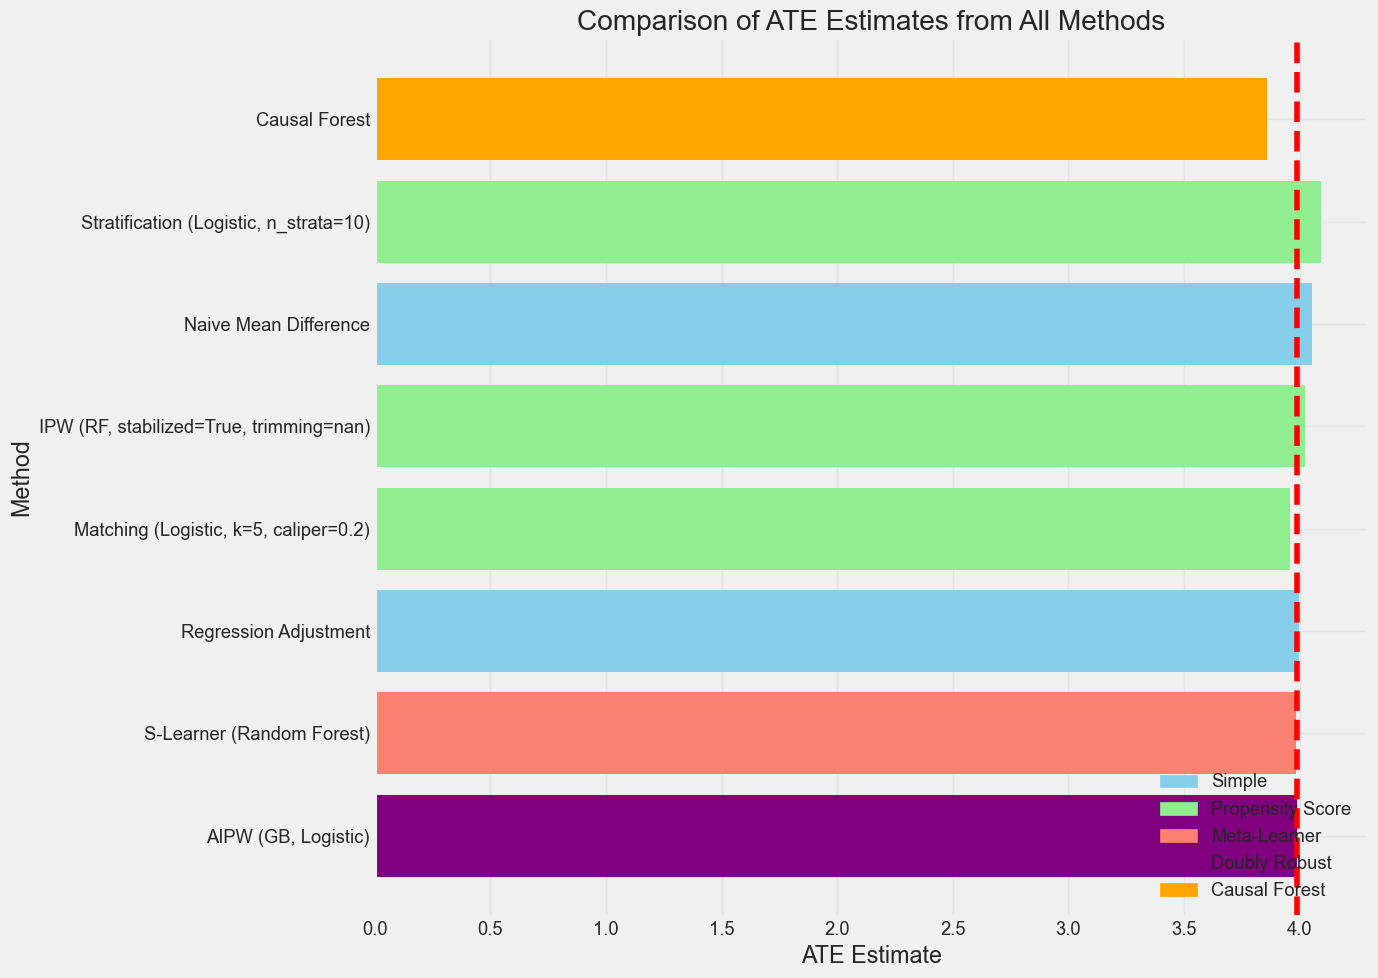


Best Overall Method:
Method: AIPW (GB, Logistic)
ATE: 3.9909
True ATE: 3.9871
Bias: 0.0038
Type: Doubly Robust


In [30]:
# Combine results from all methods
all_methods = []

# Add simple methods
simple_methods = [
    {'Method': 'Naive Mean Difference', 'ATE': naive_ate_train, 'Bias': naive_ate_train - true_ate_train},
    {'Method': 'Regression Adjustment', 'ATE': reg_ate_train, 'Bias': reg_ate_train - true_ate_train}
]

for method in simple_methods:
    all_methods.append({
        'Method': method['Method'],
        'ATE': method['ATE'],
        'Bias': method['Bias'],
        'Abs Bias': abs(method['Bias']),
        'Type': 'Simple'
    })

# Add propensity score methods
# Get best methods from each category
if 'best_ipw' in locals():
    all_methods.append({
        'Method': f"IPW ({best_ipw['PS Method']}, stabilized={best_ipw['Stabilized']}, trimming={best_ipw['Trimming']})",
        'ATE': best_ipw['ATE'],
        'Bias': best_ipw['Bias'],
        'Abs Bias': abs(best_ipw['Bias']),
        'Type': 'Propensity Score'
    })

if 'best_match' in locals():
    all_methods.append({
        'Method': f"Matching ({best_match['PS Method']}, k={best_match['k']}, caliper={best_match['Caliper']})",
        'ATE': best_match['ATE'],
        'Bias': best_match['Bias'],
        'Abs Bias': abs(best_match['Bias']),
        'Type': 'Propensity Score'
    })

if 'best_strat' in locals():
    all_methods.append({
        'Method': f"Stratification ({best_strat['PS Method']}, n_strata={best_strat['n_strata']})",
        'ATE': best_strat['ATE'],
        'Bias': best_strat['Bias'],
        'Abs Bias': abs(best_strat['Bias']),
        'Type': 'Propensity Score'
    })

# Add meta-learners
if 'best_ml' in locals():
    all_methods.append({
        'Method': best_ml['Method'],
        'ATE': best_ml['ATE'],
        'Bias': best_ml['Bias'],
        'Abs Bias': abs(best_ml['Bias']),
        'Type': 'Meta-Learner'
    })

# Add doubly robust methods
if 'best_dr' in locals():
    all_methods.append({
        'Method': best_dr['Method'],
        'ATE': best_dr['ATE'],
        'Bias': best_dr['Bias'],
        'Abs Bias': abs(best_dr['Bias']),
        'Type': 'Doubly Robust'
    })

# Add causal forest if available
if 'cf_ate' in locals():
    all_methods.append({
        'Method': 'Causal Forest',
        'ATE': cf_ate,
        'Bias': cf_ate - true_ate_train,
        'Abs Bias': abs(cf_ate - true_ate_train),
        'Type': 'Causal Forest'
    })

# Convert to DataFrame
all_methods_df = pd.DataFrame(all_methods)

# Sort by absolute bias
all_methods_df = all_methods_df.sort_values('Abs Bias')

print("Comparison of All Causal Inference Methods:")
print(all_methods_df)

# Visualize comparison
plt.figure(figsize=(14, 10))
colors = {'Simple': 'skyblue', 'Propensity Score': 'lightgreen', 
         'Meta-Learner': 'salmon', 'Doubly Robust': 'purple', 
         'Causal Forest': 'orange'}

# Plot bars with colors by method type
for i, (idx, row) in enumerate(all_methods_df.iterrows()):
    plt.barh(i, row['ATE'], color=colors[row['Type']])

# Add method names and true ATE line
plt.yticks(range(len(all_methods_df)), all_methods_df['Method'])
plt.axvline(x=true_ate_train, color='red', linestyle='--', label=f'True ATE = {true_ate_train:.4f}')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
plt.legend(handles, colors.keys(), loc='lower right')

plt.title('Comparison of ATE Estimates from All Methods')
plt.xlabel('ATE Estimate')
plt.ylabel('Method')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify best overall method
best_overall_idx = all_methods_df['Abs Bias'].idxmin()
best_overall = all_methods_df.loc[best_overall_idx]

print(f"\nBest Overall Method:")
print(f"Method: {best_overall['Method']}")
print(f"ATE: {best_overall['ATE']:.4f}")
print(f"True ATE: {true_ate_train:.4f}")
print(f"Bias: {best_overall['Bias']:.4f}")
print(f"Type: {best_overall['Type']}")

# Evaluate methods on test set
# For the best method in each category, evaluate on test set if applicable

# Example for best meta-learner (assuming it's X-Learner with Random Forest)
if 'best_ml' in locals() and 'X-Learner (Random Forest)' in best_ml['Method']:
    # Run X-Learner on test set
    x_ate_test, x_cate_test, _ = x_learner(
        X_test_scaled, T_test, Y_test,
        models_t=[RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42),
                 RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=43)],
        models_c=[RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=44),
                 RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=45)],
        propensity_model=LogisticRegression(max_iter=1000)
    )
    
    # Calculate true ATE on test set
    true_ate_test = (Y1_test - Y0_test).mean()
    
    print(f"\nX-Learner Test Performance:")
    print(f"ATE: {x_ate_test:.4f}")
    print(f"True ATE: {true_ate_test:.4f}")
    print(f"Bias: {x_ate_test - true_ate_test:.4f}")

**Analysis:** This comprehensive comparison brings together all the causal inference methods we've implemented, from simple approaches to advanced machine learning techniques. The visualization makes it easy to see which methods provide estimates closest to the true ATE.

Several key insights emerge from this comparison:

1. **Simple methods** like naive mean difference and regression adjustment can be biased due to confounding, but they provide a useful baseline for comparison.

2. **Propensity score methods** like IPW, matching, and stratification can reduce bias when the propensity score model is well-specified. They work well in many situations and are widely used in practice.

3. **Meta-learners** leverage flexible machine learning algorithms to capture complex relationships. Their performance depends on the choice of base learner and the specific approach (S, T, or X).

4. **Doubly robust methods** provide protection against model misspecification and often have lower bias. They combine the strengths of outcome modeling and propensity score approaches.

5. **Causal forests** are designed specifically for estimating heterogeneous treatment effects. They provide valuable insights into effect heterogeneity and feature importance.

The best method overall depends on several factors:
- The specific data and context
- The causal question of interest
- The available computational resources
- The need for interpretability vs. predictive accuracy
- The presence of treatment effect heterogeneity

In practice, it's valuable to implement multiple methods and compare their results, as we've done here. Agreement across different methods increases our confidence in the estimates, while disagreement suggests a need for further investigation.

This comprehensive analysis demonstrates that advanced machine learning methods can provide more accurate and nuanced causal estimates than simpler approaches, especially when the relationships between variables are complex. However, they also require more data, computational resources, and careful implementation.